# Collapsible Sidebar Usage Analysis

[Task](https://phabricator.wikimedia.org/T245735)

# Background/Purpose

A collapsible sidebar was deployed as an opt-out feature to test wikis as part of the new vector skin on desktop. This was the  first change as part of the [Desktop Improvements Project](https://www.mediawiki.org/wiki/Reading/Web/Desktop_Improvements) and allows users to collapse the lengthy menu found on the left side of each page.

The sidebar was deployed as open by default for all users and the status preserved for logged-in users across sessions. The purpose of this analysis is to investigate how the collapsible sidebar is affecting user behavior.

Data includes events recorded from 22 July 2020 through 31 August 2020 from the [DesktopWebUIActionsSchema](https://meta.wikimedia.org/wiki/Schema:DesktopWebUIActionsTracking). We also reviewed events recorded in [pageview_hourly](https://wikitech.wikimedia.org/wiki/Analytics/Data_Lake/Traffic/Pageview_hourly) table and [webrequest](https://wikitech.wikimedia.org/wiki/Analytics/Data_Lake/Traffic/Webrequest) to understand dekstop interaction prior to the deployment of the collapsible sidebar and instrumentation.

**Deployment Dates**

| project | Wed. July 22 | Tues. July 28 | Wed. Aug 5|
|--------------|------------|-------------|-------------|
| euwiki (Basque Wikipedia) | x | | 
| fawiki (Persian Wikipedia) | | x | 
| frwiki (French Wikipedia) | | | x 
| frwiktionary (French Wiktionary) | x | | 
| hewiki (Hebrew Wikipedia) | | x | 
| ptwikiversity (Portuguese Wikiversity) | x | | 

# Metrics

1. [What is the frequency that users collapse and uncollapse the sidebar?](#What-is-the-frequency-that-users-collapse-and-uncollapse-the-sidebar?)
    * [What are the total and average clicks to the sidebar per session?](#What-are-the-total-and-average-clicks-to-the-sidebar-per-session?)
    * [What is the frequency of sidebar clicks in each session?](#What-is-the-frequenct-of-sidebar-clicks-in-each-session?)
    * [What percent of all sessions include a sidebar click?](#What-percent-of-all-sessions-include-a-sidebar-click?)
    
    
2. [What are the different interaction types with the sidebar?](#What-are-the-different-interaction-types-with-the-sidebar?) 
i.e. Once the sidebar is collapsed, do users open it when they need to, or do they just ignore it altogether?

  
3. [What is the overall difference in interaction with sidebar links before and after the change?](#What-is-the-overall-difference-in-interaction-with-sidebar-links-before-and-after-the-change?)
    * [How do the sidebar events per session compare for each skin type?](#How-do-the-sidebar-events-per-session-compare-for-each-skin-type?)
    * [What is the impact on the donate link?](#What-is-the-impact-on-the-donate-link?)
    * [What is the difference in sidebar link interactions pre and post deployment?](#What-is-the-difference-in-sidebar-link-interactions-pre-and-post-deployment?)


In [1005]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [2]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(tidyverse); library(glue); library(lubridate); library(scales)
})

In [3]:
options(repr.plot.width = 15, repr.plot.height = 7)

In [13]:
#deployment annotations to use in charts 

vertical_lines <- as.numeric(as.Date(c("2020-07-22", "2020-07-28", "2020-08-05")))

# What is the frequency that users collapse and uncollapse the sidebar?


## Approach

Reviewed the following:
- Number of clicks to the sidebar and average clicks per session overall and by wiki, edit count, and logged in status.
- Percent of sessions with clicks to the sidebar (either to collapse or to uncollapse)
- Frequency of number of clicks to the sidebar per session 

Note: In the section below, a sidebar click is defined as a click to either collapse or uncollapse the sidebar.


## What are the total and average clicks to the sidebar per session?

In [5]:
#collect sidebar clicks by edit count, sidebar state and wiki
query <- 
"SELECT 
    date_format(dt, 'yyyy-MM-dd') AS date,
    event.token AS session,
    wiki AS wiki,
    event.isAnon AS logged_in_status,
    event.isSidebarCollapsed AS sidebar_state,
    event.editCountBucket AS user_edit_count,
    COUNT(*) as events
FROM event.desktopwebuiactionstracking
WHERE 
-- review clicks to the sidebar
    event.name = 'ui.sidebar' 
    AND event.action = 'click'
    AND year = 2020
    AND ((month=07 AND day >= 22) OR month= 08 ) 
-- sidebar is collapsible only on new vector skin
    AND event.skinversion = 2
    AND wiki <> 'testwiki'
     AND useragent.is_bot = false
GROUP BY
    date_format(dt, 'yyyy-MM-dd'),
    event.token,
    event.isAnon,
    event.isSidebarCollapsed,
    wiki,
    event.editCountBucket
"

In [6]:
sidebar_clicks <- wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [7]:
sidebar_clicks$date <- as.Date(sidebar_clicks$date, format = "%Y-%m-%d")

In [8]:
sidebar_clicks$sidebar_state <- ifelse(sidebar_clicks$sidebar_state == 'false', "uncollapse", "collapse")

In [9]:
sidebar_clicks$logged_in_status <- ifelse(sidebar_clicks$logged_in_status == 'false', "logged-in", "logged-out")

### Overall

`summarise()` regrouping output by 'date' (override with `.groups` argument)



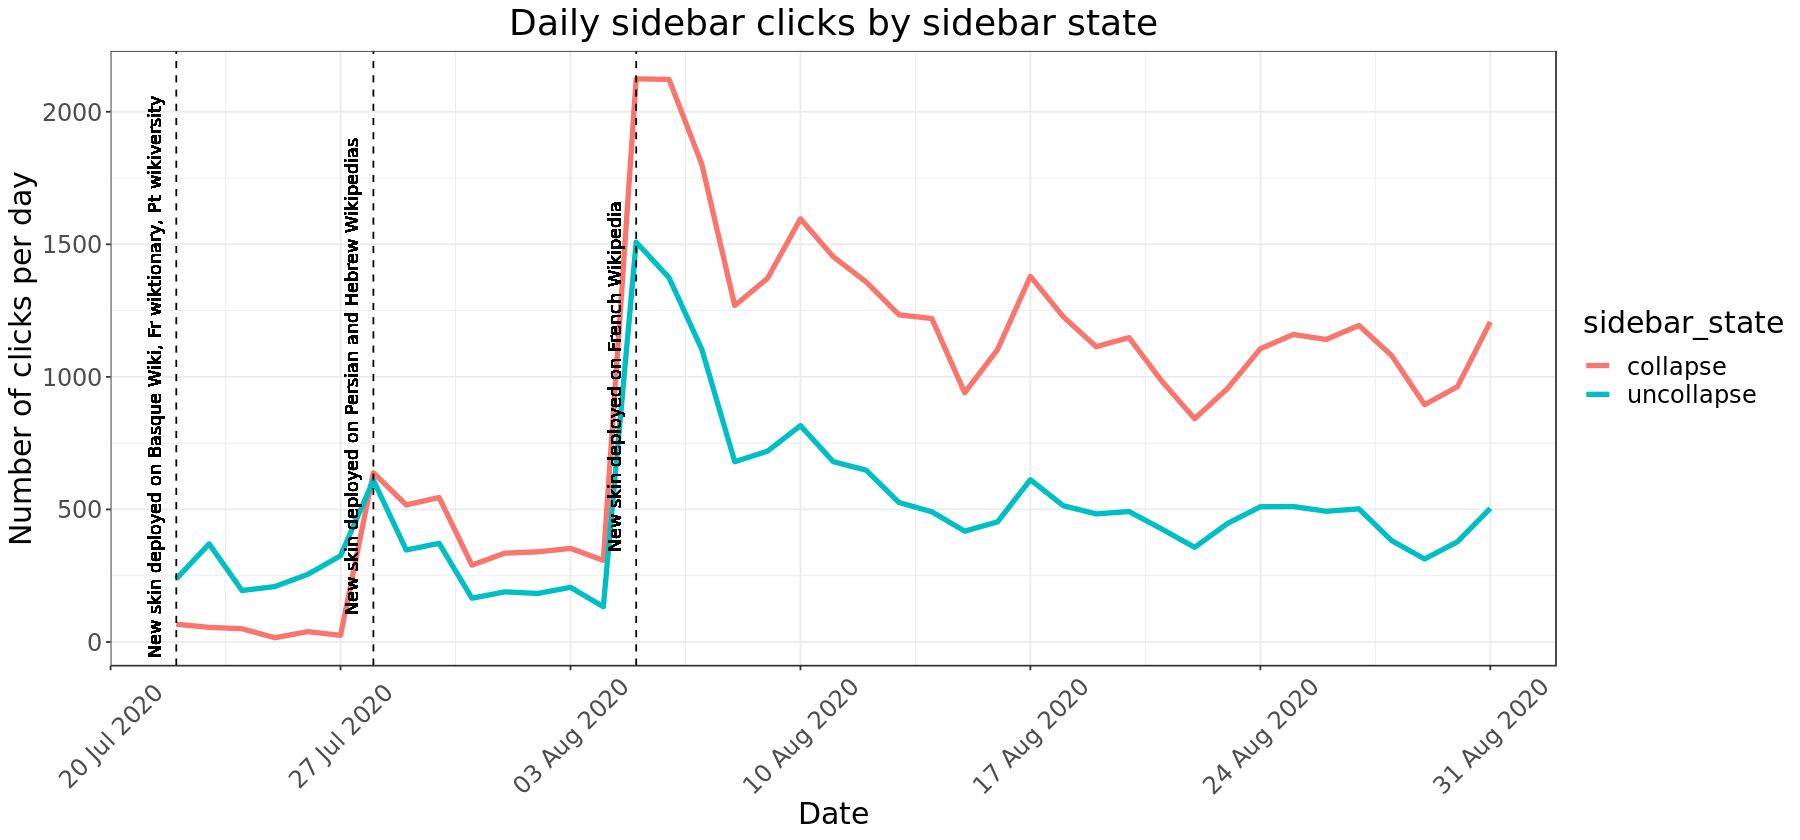

In [1007]:
# Number of collapse events vs uncollapse events

p <- sidebar_clicks %>%
    group_by(date, sidebar_state) %>%
    summarise(total_events = sum(events)) %>%
    ggplot(aes(x=date, y= total_events, color = sidebar_state)) +
        geom_line(size = 1.5) +
geom_vline(xintercept = vertical_lines,
             linetype = "dashed", color = "black") +
            geom_text(aes(x=as.Date('2020-07-22'), y=1E3, label="New skin deployed on Basque Wiki, Fr wiktionary, Pt wikiversity"), size=3.7, vjust = -1.2, angle = 90, color = "black") +
            geom_text(aes(x=as.Date('2020-07-28'), y=1E3, label="New skin deployed on Persian and Hebrew Wikipedias"), size=3.7, vjust = -1.2, angle = 90, color = "black") +
            geom_text(aes(x=as.Date('2020-08-05'), y=1E3, label="New skin deployed on French Wikipedia"), size=3.7, vjust = -1.2, angle = 90, color = "black") +
        scale_x_date("Date", labels = date_format("%d %b %Y"), date_breaks = "1 week") +
        scale_y_continuous("Number of clicks per day") +
        labs (title = "Daily sidebar clicks by sidebar state")  +
        theme_bw() +
        theme(
        plot.title = element_text(hjust = 0.5),
        axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=0.5),
        text = element_text(size=18))
p

ggsave("Figures/daily_sidebar_clicks_overall.png", p, width = 16, height = 8, units = "in", dpi = 300)

#### Overall Avearge Clicks Per Session

In [243]:
count_events_overall <- sidebar_clicks %>%
    summarize(num_events = sum(events),
            num_sessions = n_distinct(session),
            avg_clicks = num_events/num_sessions)

count_events_overall

num_events,num_sessions,avg_clicks
<int>,<int>,<dbl>
57703,28723,2.008948


#### Overall Avearge Clicks Per Session By Sidebar State

In [246]:
count_events_bysidebarstatus <- sidebar_clicks %>%
    group_by(sidebar_state) %>%
    summarize(num_events = sum(events),
            num_sessions = n_distinct(session),
            avg_clicks = num_events/num_sessions)

count_events_bysidebarstatus 

`summarise()` ungrouping output (override with `.groups` argument)



sidebar_state,num_events,num_sessions,avg_clicks
<chr>,<int>,<int>,<dbl>
collapse,37566,27502,1.365937
uncollapse,20137,14635,1.375948


There is a sharp increases in number of clicks to the sidebar (both to either collapse or uncollapse) following each deployment. Following the last deployment to French Wikipedia on August 5th, the number of clicks to the sidebar have begun to stabilize to around 1400 to 1700 clicks per day. 

From the first deployment on July 22nd to the end of August 2020, there have been a total of 57,703 clicks to either collapse or uncollapse sidebar by 28,723 unique search sessions. There is an average 2 sidebar clicks per session.


Since the sidebar was set as uncollapsed by default, there are more clicks to collapse the sidebar. There are roughly the same average number of clicks per session (1.3) to either collapse or uncollapse. 

### By Wiki

`summarise()` regrouping output by 'date' (override with `.groups` argument)



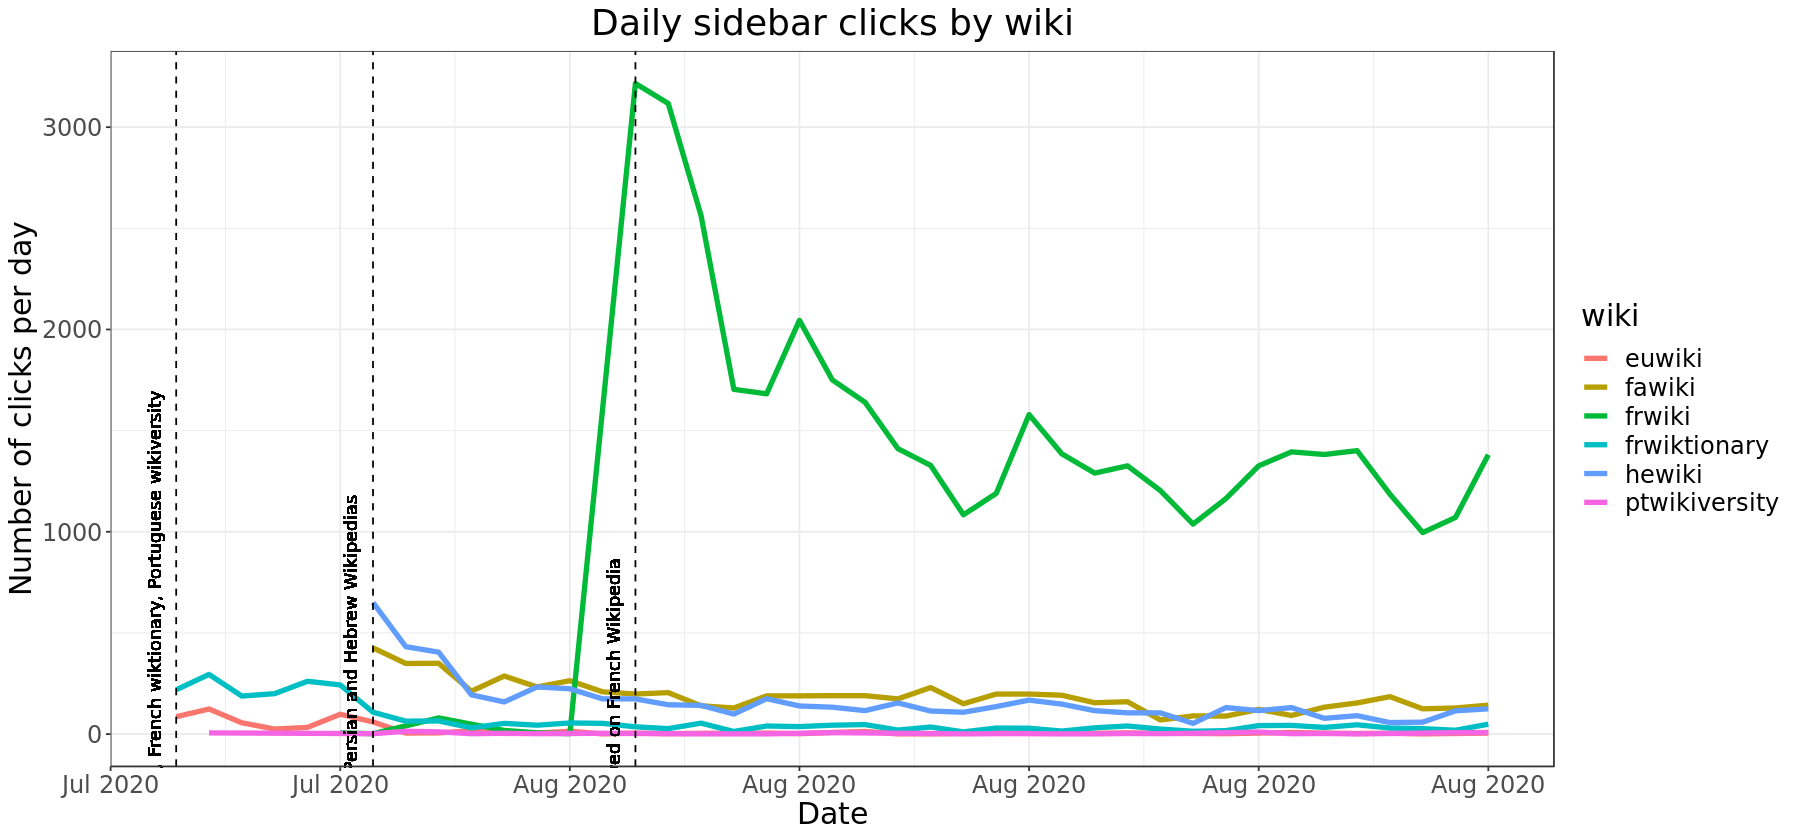

In [921]:
#Chart overall sidebar clicks over time by wiki

p <- sidebar_clicks %>%
    group_by(date, wiki) %>%
    summarise(total_clicks = sum(events),
              avg_clicks = sum(events)/n_distinct(session)) %>%
    ggplot(aes(x=date, y= total_clicks, color = wiki)) +
        geom_line(size = 1.5) +
geom_vline(xintercept = vertical_lines,
             linetype = "dashed", color = "black") +
            geom_text(aes(x=as.Date('2020-07-22'), y=2.5, label="New skin deployed on Basque Wiki, French wiktionary, Portuguese wikiversity"), size=3.7, vjust = -1.2, angle = 90, color = "black") +
            geom_text(aes(x=as.Date('2020-07-28'), y=2.5, label="New skin deployed on Persian and Hebrew Wikipedias"), size=3.7, vjust = -1.2, angle = 90, color = "black") +
            geom_text(aes(x=as.Date('2020-08-05'), y=2.5, label="New skin deployed on French Wikipedia"), size=3.7, vjust = -1.2, angle = 90, color = "black") +
        scale_x_date("Date", labels = date_format("%b %Y"), date_breaks = "1 week") +
        scale_y_continuous("Number of clicks per day") +
        labs (title = "Daily sidebar clicks by wiki")  +
        theme_bw() +
        theme(
        plot.title = element_text(hjust = 0.5),,
        text = element_text(size=18))
p

ggsave("Figures/daily_sidebar_clicks_bywiki.png", p, width = 16, height = 8, units = "in", dpi = 300)

#### Overall Average Clicks Per Session By Wiki

In [924]:
# average clicks per wiki 
sidebar_clicks_bywiki <- sidebar_clicks %>%
    group_by(wiki) %>%
    summarize(total_events = sum(events),
              unique_sessions = n_distinct(session),
              avg_events_persession = total_events/unique_sessions)

sidebar_clicks_bywiki

`summarise()` ungrouping output (override with `.groups` argument)



wiki,total_events,unique_sessions,avg_events_persession
<chr>,<int>,<int>,<dbl>
euwiki,638,260,2.453846
fawiki,6549,2223,2.946019
frwiki,41969,21902,1.916218
frwiktionary,2733,1458,1.874486
hewiki,5704,2826,2.018401
ptwikiversity,110,54,2.037037


French Wiktionary  had the lowest average sidebar clicks per session (1.87) while Persian Wikipedia had the highest (2.94)

`summarise()` regrouping output by 'date', 'wiki' (override with `.groups` argument)



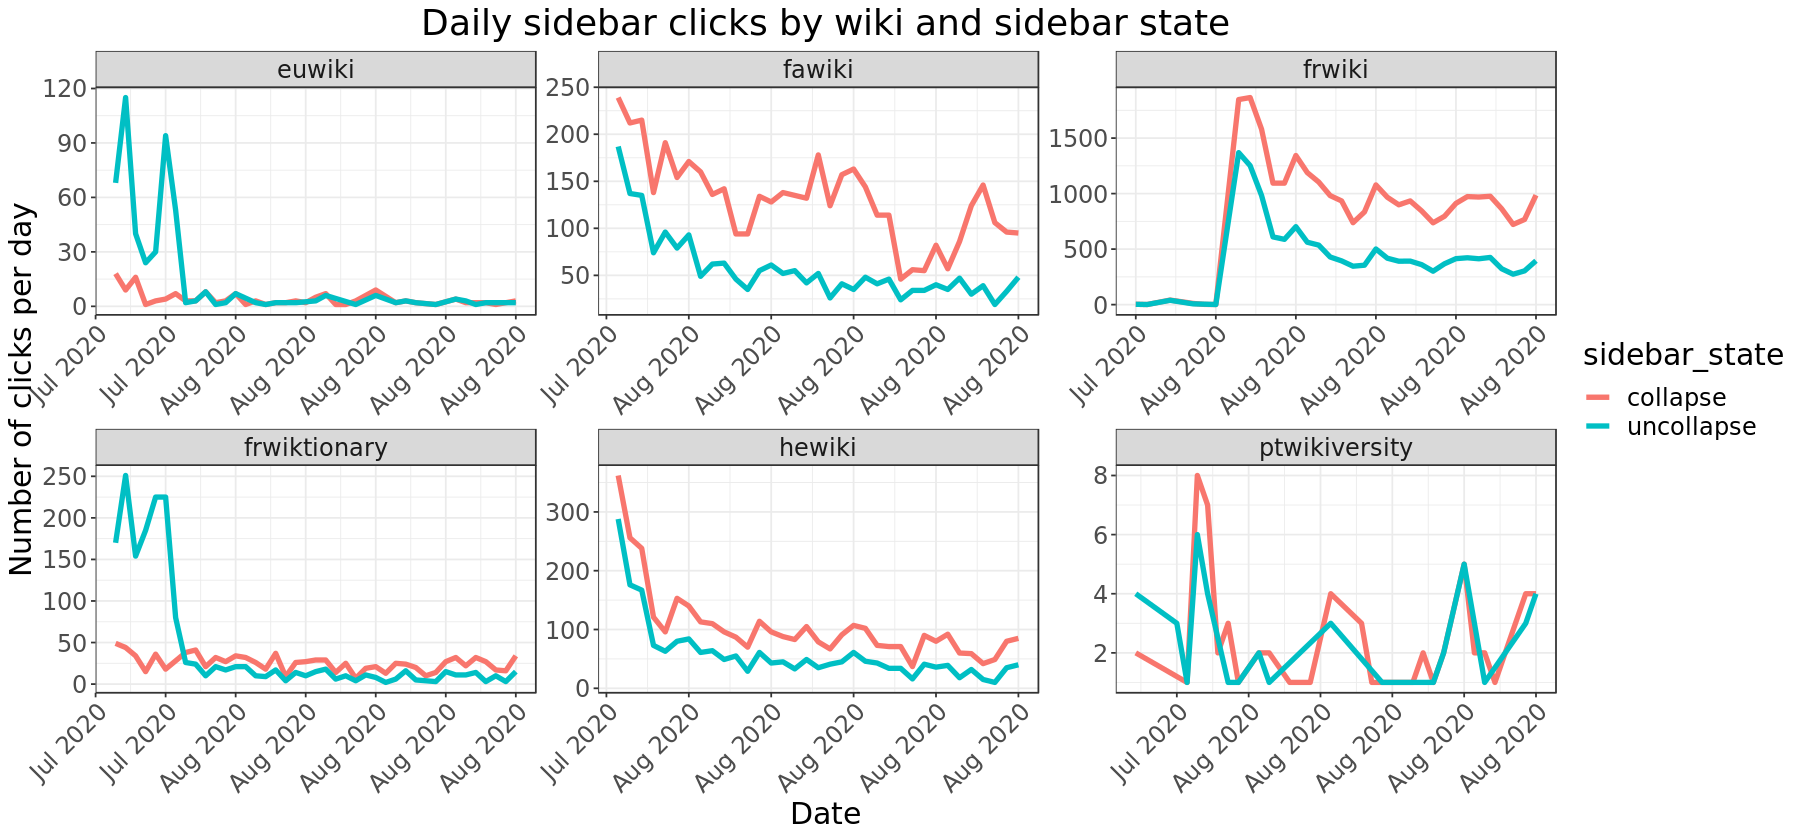

In [922]:
p <- sidebar_clicks %>%
    group_by(date, wiki, sidebar_state) %>%
    summarise(total_events = sum(events)) %>%
    ggplot(aes(x = date, y= total_events, color = sidebar_state)) +
        geom_line(size = 1.5) +
        facet_wrap(~wiki, scales = "free") +
        scale_x_date("Date", labels = date_format("%b %Y"), date_breaks = "1 week") +
        scale_y_continuous("Number of clicks per day") +
        labs (title = "Daily sidebar clicks by wiki and sidebar state")  +
        theme_bw() +
        theme(
        plot.title = element_text(hjust = 0.5),,
        text = element_text(size=18),
        axis.text.x = element_text(angle = 45, hjust = 1))
p

ggsave("Figures/daily_sidebar_clicks_wiki_sidebarstate.png", p, width = 16, height = 8, units = "in", dpi = 300)

`summarise()` regrouping output by 'wiki' (override with `.groups` argument)



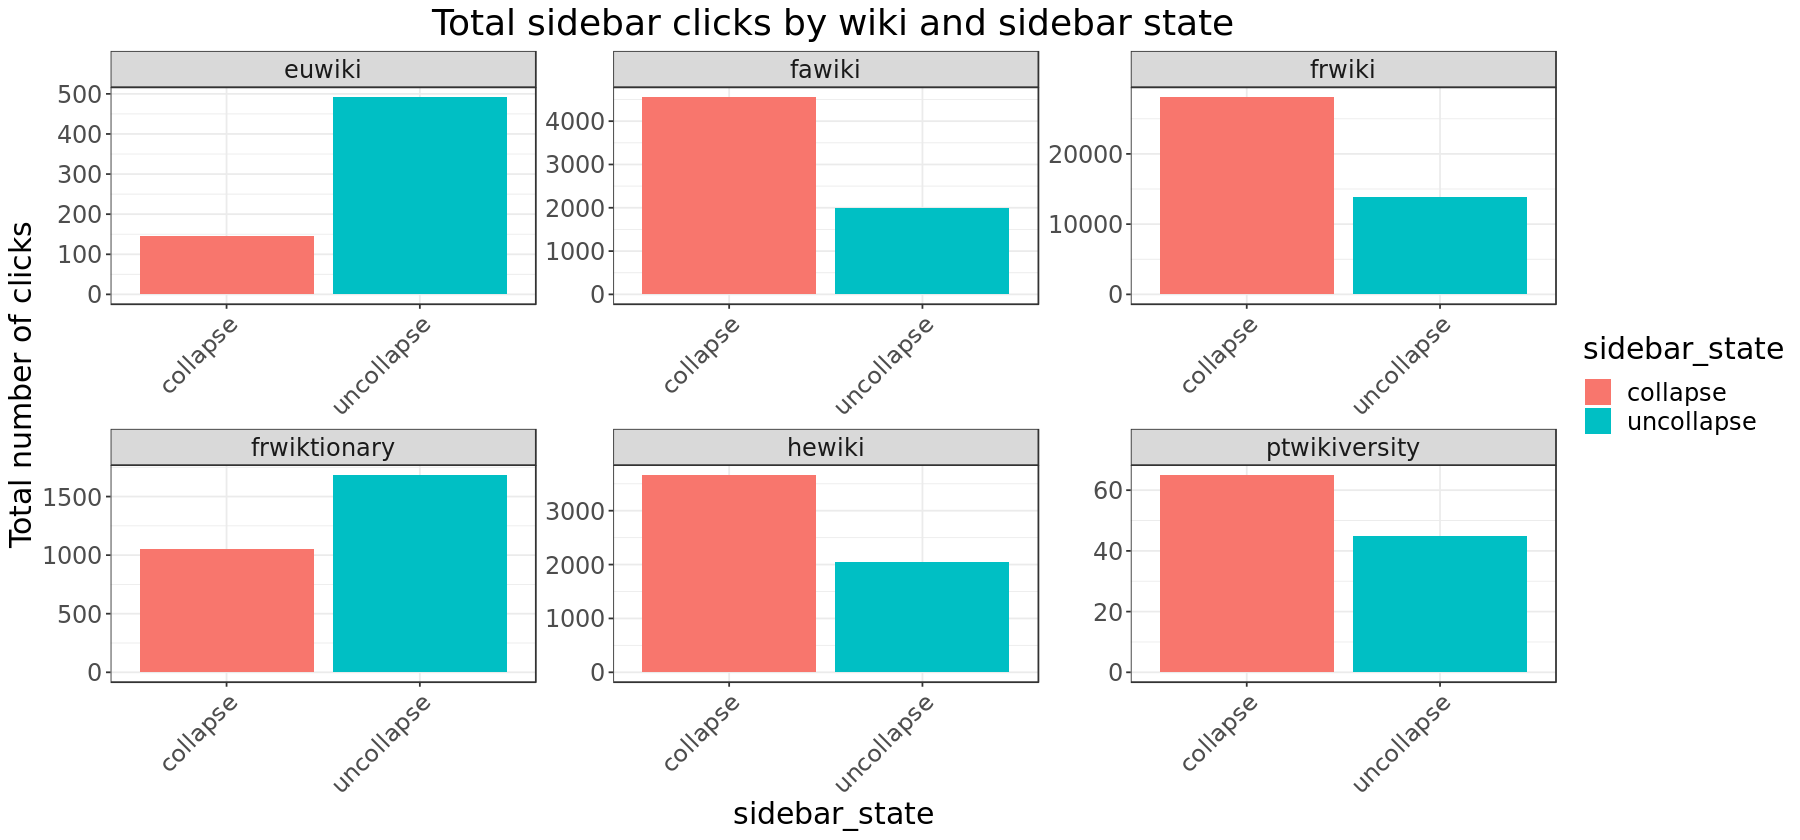

In [928]:
p <- sidebar_clicks %>%
    group_by(wiki, sidebar_state) %>%
    summarise(total_events = sum(events)) %>%
    ggplot(aes(x = sidebar_state, y= total_events, fill = sidebar_state)) +
        geom_bar(stat = 'identity') +
         facet_wrap(~wiki, scales = "free") +
        scale_y_continuous("Total number of clicks") +
        labs (title = "Total sidebar clicks by wiki and sidebar state")  +
        theme_bw() +
        theme(
        plot.title = element_text(hjust = 0.5),,
        text = element_text(size=18),
        axis.text.x = element_text(angle = 45, hjust = 1))
p

ggsave("Figures/total_sidebar_clicks_bywiki.png", p, width = 16, height = 8, units = "in", dpi = 300)

There are a higher number of collapse events compared to uncollapse events for Persian Wikipedia, French Wikipedia, Hebrew Wikipedia and Portuguese Wikiversity, which makes sense as the sidebar was presented as uncollapsed as default. Ptwikiversity has a very low number of clicks to either collapse or uncollapse the sidebar (only 2 to 8 per day).

Interestingly, Basque Wikipedia and French Wiktionary had a higher number of clicks to uncollapse the sidebar despite the sidebar being uncollapsed as default. Both of these wikis also had a signficantly higher average number of uncollapse clicks per session.

#### Average Clicks Per Session By Wiki and Sidebar State

In [927]:
# average clicks per wiki 
sidebar_clicks_bywiki_sidebarstatus <- sidebar_clicks %>%
    group_by(wiki, sidebar_state) %>%
    summarize(total_events = sum(events),
              unique_sessions = n_distinct(session),
              avg_events_persession = total_events/unique_sessions)

sidebar_clicks_bywiki_sidebarstatus

`summarise()` regrouping output by 'wiki' (override with `.groups` argument)



wiki,sidebar_state,total_events,unique_sessions,avg_events_persession
<chr>,<chr>,<int>,<int>,<dbl>
euwiki,collapse,146,115,1.269565
euwiki,uncollapse,492,231,2.129870
fawiki,collapse,4556,2169,2.100507
fawiki,uncollapse,1993,1318,1.512140
frwiki,collapse,28087,21601,1.300264
frwiki,uncollapse,13882,10545,1.316453
frwiktionary,collapse,1049,817,1.283966
frwiktionary,uncollapse,1684,1052,1.600760
hewiki,collapse,3663,2753,1.330548


### By Edit Count

`summarise()` regrouping output by 'date' (override with `.groups` argument)



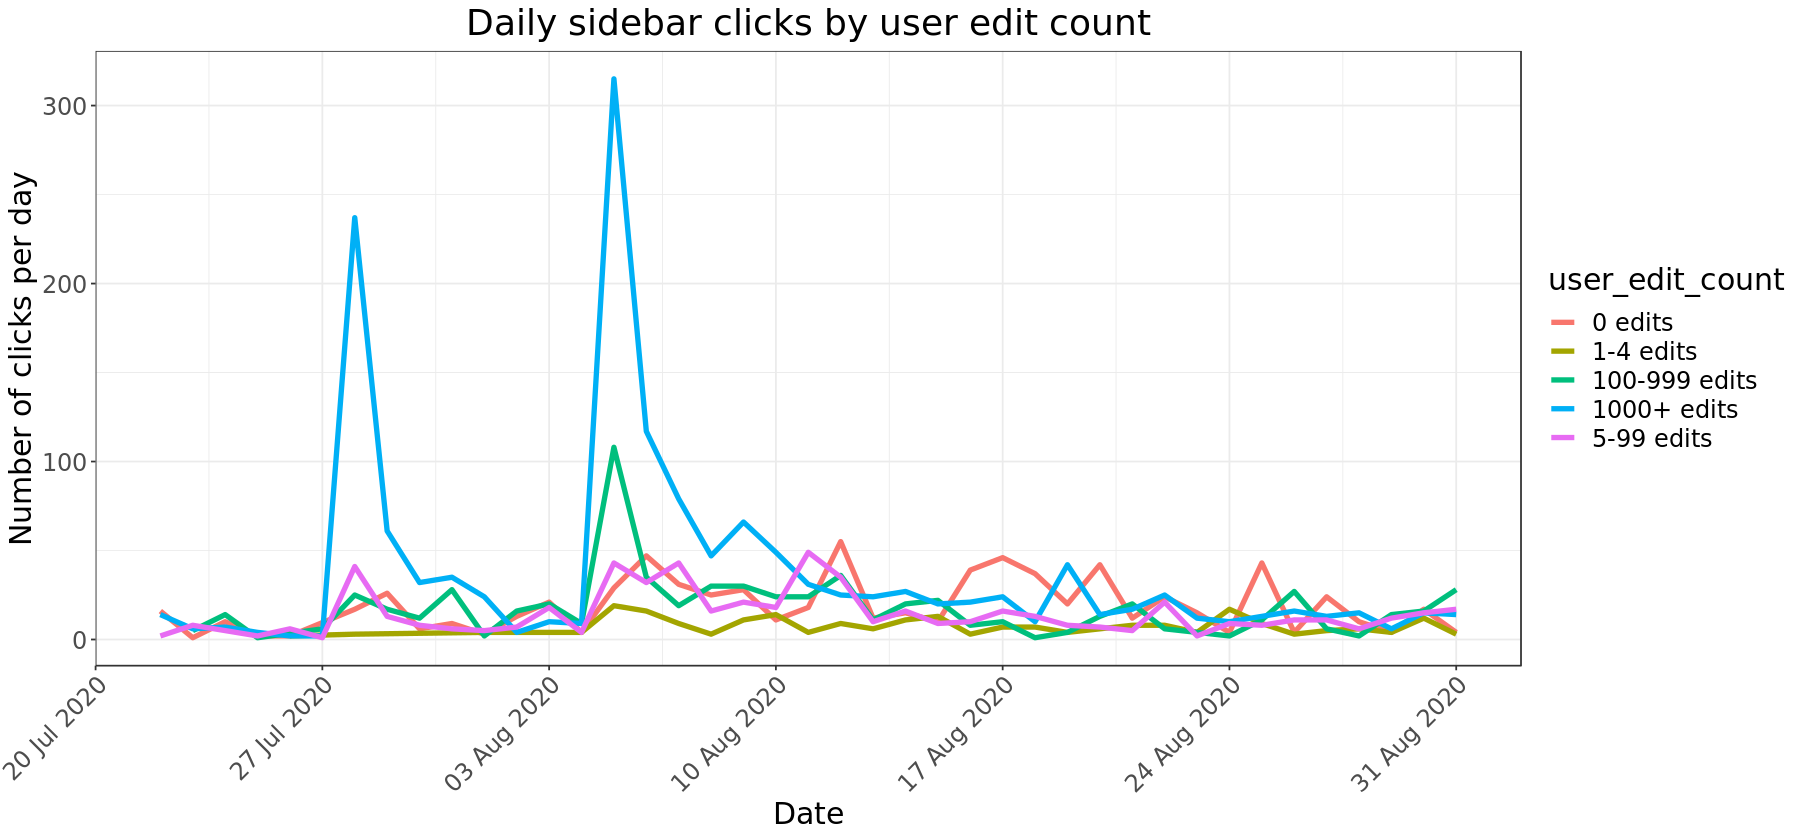

In [946]:
p <- sidebar_clicks %>%
# remove anonymous users
    filter(logged_in_status == 'logged-in') %>%
    group_by(date, user_edit_count) %>%
    summarise(total_events = sum(events)) %>%
    ggplot(aes(x=date, y= total_events, color = user_edit_count)) +
        geom_line(size = 1.5) +
        scale_y_continuous("Number of clicks per day") +
        scale_x_date("Date", labels = date_format("%d %b %Y"), date_breaks = "1 week") +
        labs (title = "Daily sidebar clicks by user edit count")  +
        theme_bw() +
        theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=18),
        axis.text.x = element_text(angle = 45, hjust = 1))
p

ggsave("Figures/daily_sidebar_clicks_byusereditcount.png", p, width = 16, height = 8, units = "in", dpi = 300)

#### Average sidebar clicks per session by edit count

In [947]:
# average clicks per editcount 
sidebar_clicks_byeditcount <- sidebar_clicks %>%
# remove anonymous users
    filter(logged_in_status == 'logged-in') %>%
    group_by(user_edit_count) %>%
    summarize(total_events = sum(events),
              unique_sessions = n_distinct(session),
              avg_events_persession = total_events/unique_sessions)

sidebar_clicks_byeditcount

`summarise()` ungrouping output (override with `.groups` argument)



user_edit_count,total_events,unique_sessions,avg_events_persession
<chr>,<int>,<int>,<dbl>
0 edits,756,270,2.800000
1-4 edits,238,109,2.183486
100-999 edits,682,239,2.853556
1000+ edits,1514,591,2.561760
5-99 edits,584,237,2.464135


There was a high daily number of sidebar clicks for users with over 1000+ edits on the deployment dates of July 28th and August 5th. The daily number of sidebar clicks have since stabilized with all edit groups having between 2 to 3 average number of events per session.  

The highest average clicks per session (2.85 clicks per session) was for users with between 100 and 199 cumulative edits and the lowest was for users with 1-4 edits (2.18 clicks per session). 

`summarise()` regrouping output by 'date', 'user_edit_count' (override with `.groups` argument)



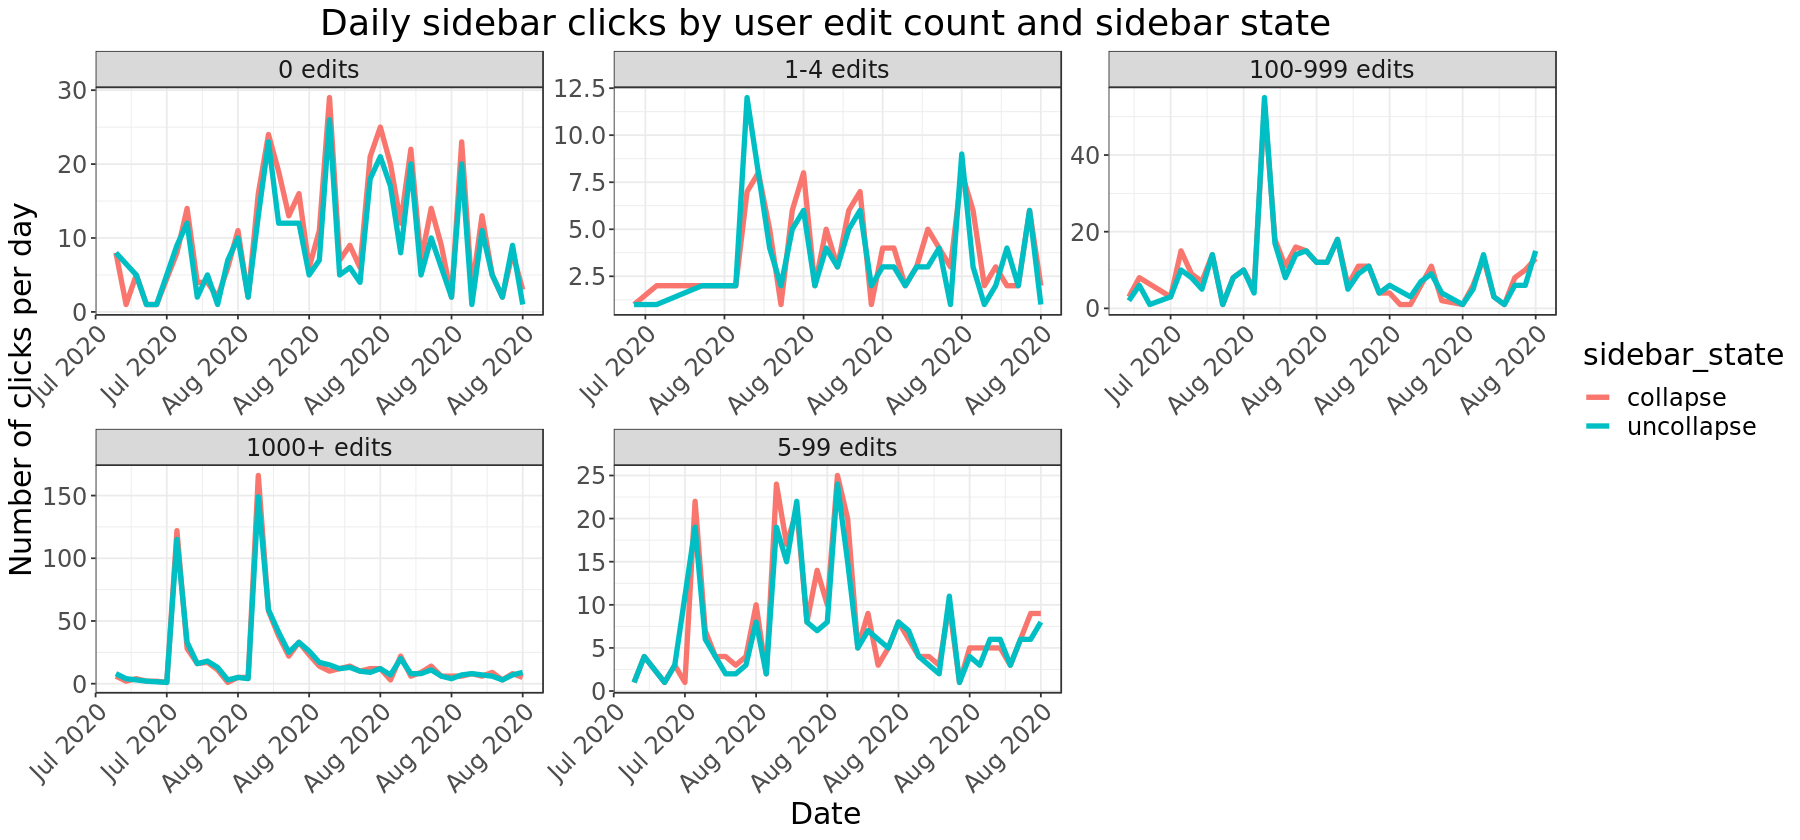

In [952]:
p <- sidebar_clicks %>%
# remove anonymous users
    filter(logged_in_status == 'logged-in') %>%
    group_by(date, user_edit_count, sidebar_state) %>%
    summarise(total_events = sum(events)) %>%
    ggplot(aes(x = date, y= total_events, color = sidebar_state)) +
        geom_line(size = 1.5) +
        facet_wrap(~user_edit_count, scales = "free") +
        scale_x_date("Date", labels = date_format("%b %Y"), date_breaks = "1 week") +
        scale_y_continuous("Number of clicks per day") +
        labs (title = "Daily sidebar clicks by user edit count and sidebar state")  +
        theme_bw() +
        theme(
        plot.title = element_text(hjust = 0.5),,
        text = element_text(size=18),
        axis.text.x = element_text(angle = 45, hjust = 1))
p

ggsave("Figures/daily_sidebar_clicks_byusereditcount_sidebarstate.png", p, width = 16, height = 8, units = "in", dpi = 300)

`summarise()` regrouping output by 'user_edit_count' (override with `.groups` argument)



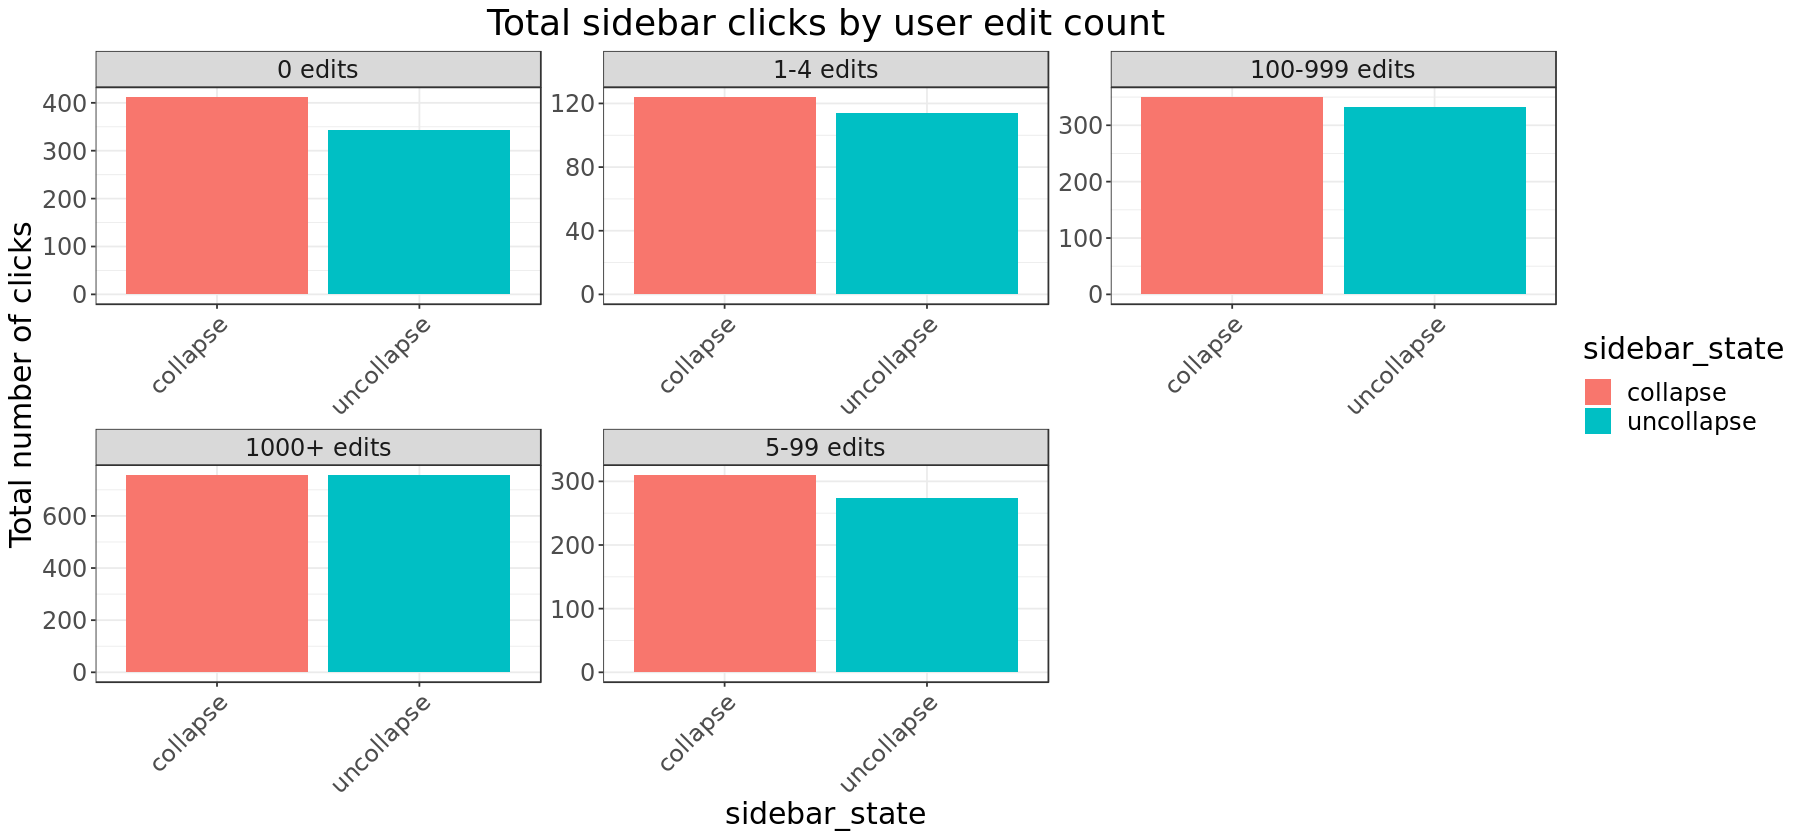

In [949]:
p <- sidebar_clicks %>%
# remove logged in users
    filter(logged_in_status == 'logged-in') %>%
    group_by(user_edit_count, sidebar_state) %>%
    summarise(total_events = sum(events)) %>%
    ggplot(aes(x=sidebar_state, y= total_events, fill = sidebar_state)) +
        geom_col() +
        facet_wrap(~user_edit_count, scales = 'free') +
        scale_y_continuous("Total number of clicks") +
        labs (title = "Total sidebar clicks by user edit count")  +
        theme_bw() +
        theme(
        plot.title = element_text(hjust = 0.5),,
        text = element_text(size=18),
        axis.text.x = element_text(angle = 45, hjust = 1))
p

ggsave("Figures/total_sidebar_clicks_byusereditcount_sidebarstate.png", p, width = 16, height = 8, units = "in", dpi = 300)

#### Average sidebar clicks per session by edit count and sidebar state

In [951]:
# average clicks per editcount 
sidebar_clicks_byeditcount <- sidebar_clicks %>%
# remove logged in users
    filter(logged_in_status == 'logged-in') %>%
    group_by(user_edit_count, sidebar_state) %>%
    summarize(total_events = sum(events),
              unique_sessions = n_distinct(session),
              avg_events = total_events/unique_sessions)

sidebar_clicks_byeditcount

`summarise()` regrouping output by 'user_edit_count' (override with `.groups` argument)



user_edit_count,sidebar_state,total_events,unique_sessions,avg_events
<chr>,<chr>,<int>,<int>,<dbl>
0 edits,collapse,412,248,1.661290
0 edits,uncollapse,344,212,1.622642
1-4 edits,collapse,124,97,1.278351
1-4 edits,uncollapse,114,85,1.341176
100-999 edits,collapse,350,213,1.643192
100-999 edits,uncollapse,332,200,1.660000
1000+ edits,collapse,757,463,1.634989
1000+ edits,uncollapse,757,481,1.573805
5-99 edits,collapse,310,212,1.462264


For most all of the edit groups, there is a higher number of collapse events vs uncollapse events. This is expected as the sidebar is presented as uncollapsed by default to all users. For higher edit count groups (100+ edits and 100-999 edits), there almost an equal proportion of collapse and uncollapse events total indicating that these groups might more frequently collapse and uncollapse the sidebar multiple times within a session. 



###  By Logged in vs logged out users

`summarise()` regrouping output by 'date' (override with `.groups` argument)



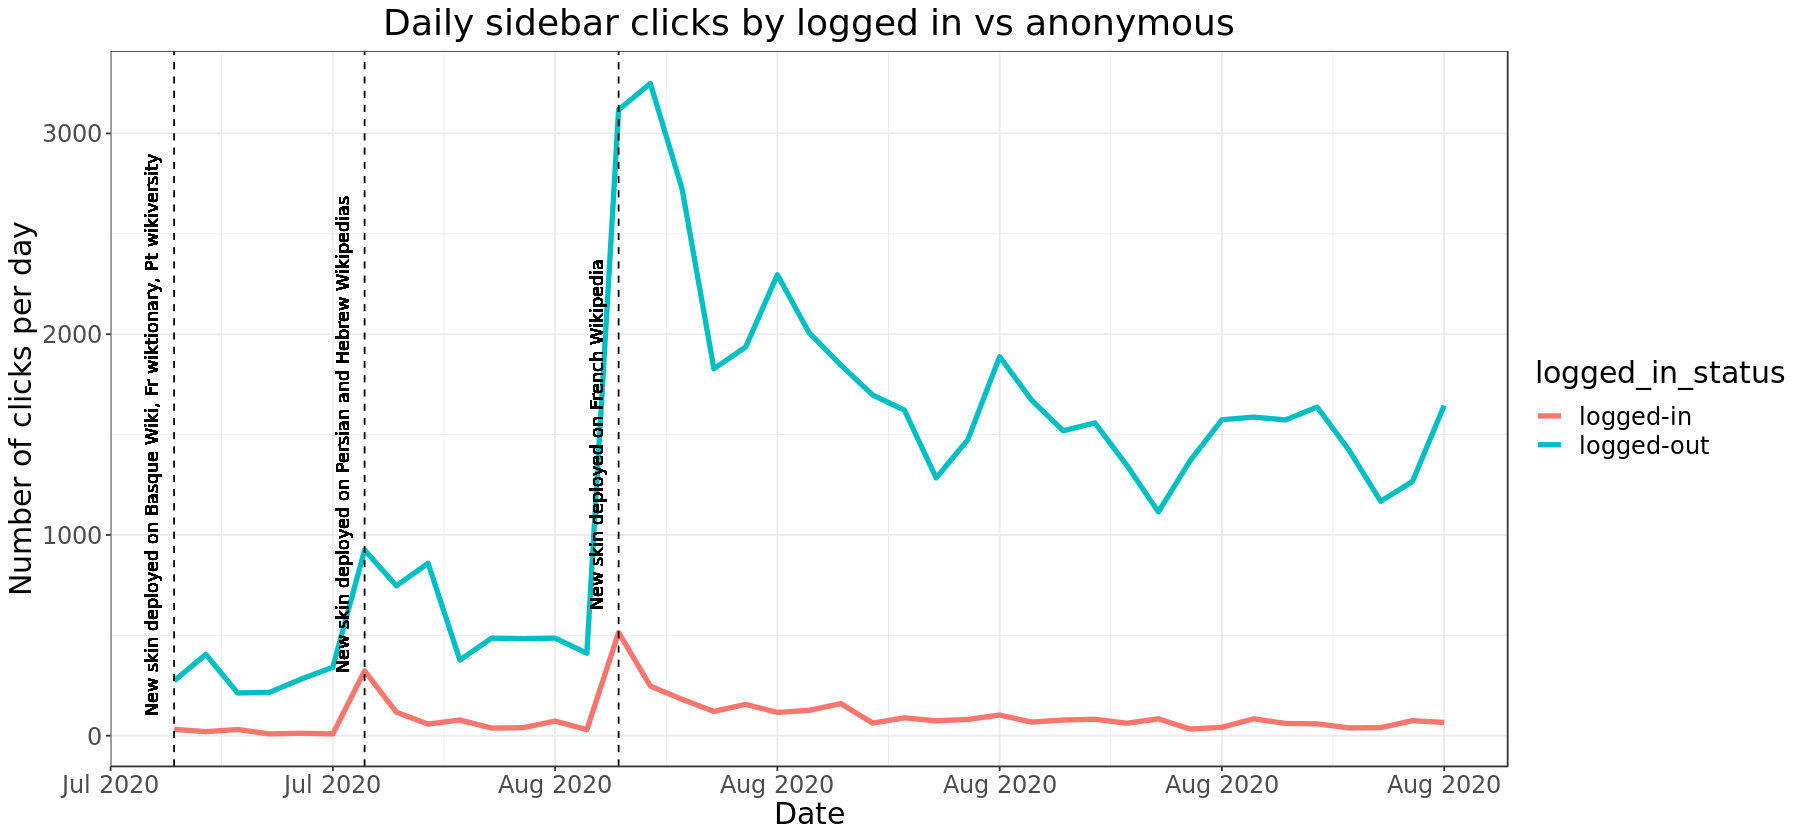

In [957]:
#Chart overall sidebar clicks over time by logged in vs logged out

p <- sidebar_clicks %>%
    group_by(date, logged_in_status) %>%
    summarise(total_clicks = sum(events),
              avg_clicks = sum(events)/n_distinct(session)) %>%
    ggplot(aes(x=date, y= total_clicks, color = logged_in_status)) +
        geom_line(size = 1.5) +
geom_vline(xintercept = vertical_lines,
             linetype = "dashed", color = "black") +
            geom_text(aes(x=as.Date('2020-07-22'), y=1.5E3, label="New skin deployed on Basque Wiki, Fr wiktionary, Pt wikiversity"), size=3.7, vjust = -1.2, angle = 90, color = "black") +
            geom_text(aes(x=as.Date('2020-07-28'), y=1.5E3, label="New skin deployed on Persian and Hebrew Wikipedias"), size=3.7, vjust = -1.2, angle = 90, color = "black") +
            geom_text(aes(x=as.Date('2020-08-05'), y=1.5E3, label="New skin deployed on French Wikipedia"), size=3.7, vjust = -1.2, angle = 90, color = "black") +
        scale_x_date("Date", labels = date_format("%b %Y"), date_breaks = "1 week") +
        scale_y_continuous("Number of clicks per day") +
        labs (title = "Daily sidebar clicks by logged in vs anonymous")  +
        theme_bw() +
        theme(
        plot.title = element_text(hjust = 0.5),,
        text = element_text(size=18))
p

ggsave("Figures/daily_sidebar_clicks_byloggedin.png", p, width = 16, height = 8, units = "in", dpi = 300)




There are more sidebar clicks by logged-out users vs logged-in users, which is expected as there are more logged-out sessions. Both follow similar trends with increases in total number of clicks around the deployment dates.

#### Average clicks per session by logged in status

In [270]:
# average clicks per logged in status 
sidebar_clicks_byanon <- sidebar_clicks %>%
    group_by(logged_in_status) %>%
    summarize(total_events = sum(events),
              unique_sessions = n_distinct(session),
              avg_events = total_events/unique_sessions)

sidebar_clicks_byanon

`summarise()` ungrouping output (override with `.groups` argument)



logged_in_status,total_events,unique_sessions,avg_events
<chr>,<int>,<int>,<dbl>
logged-in,3774,1445,2.611765
logged-out,53929,27301,1.975349


`summarise()` regrouping output by 'date', 'logged_in_status' (override with `.groups` argument)



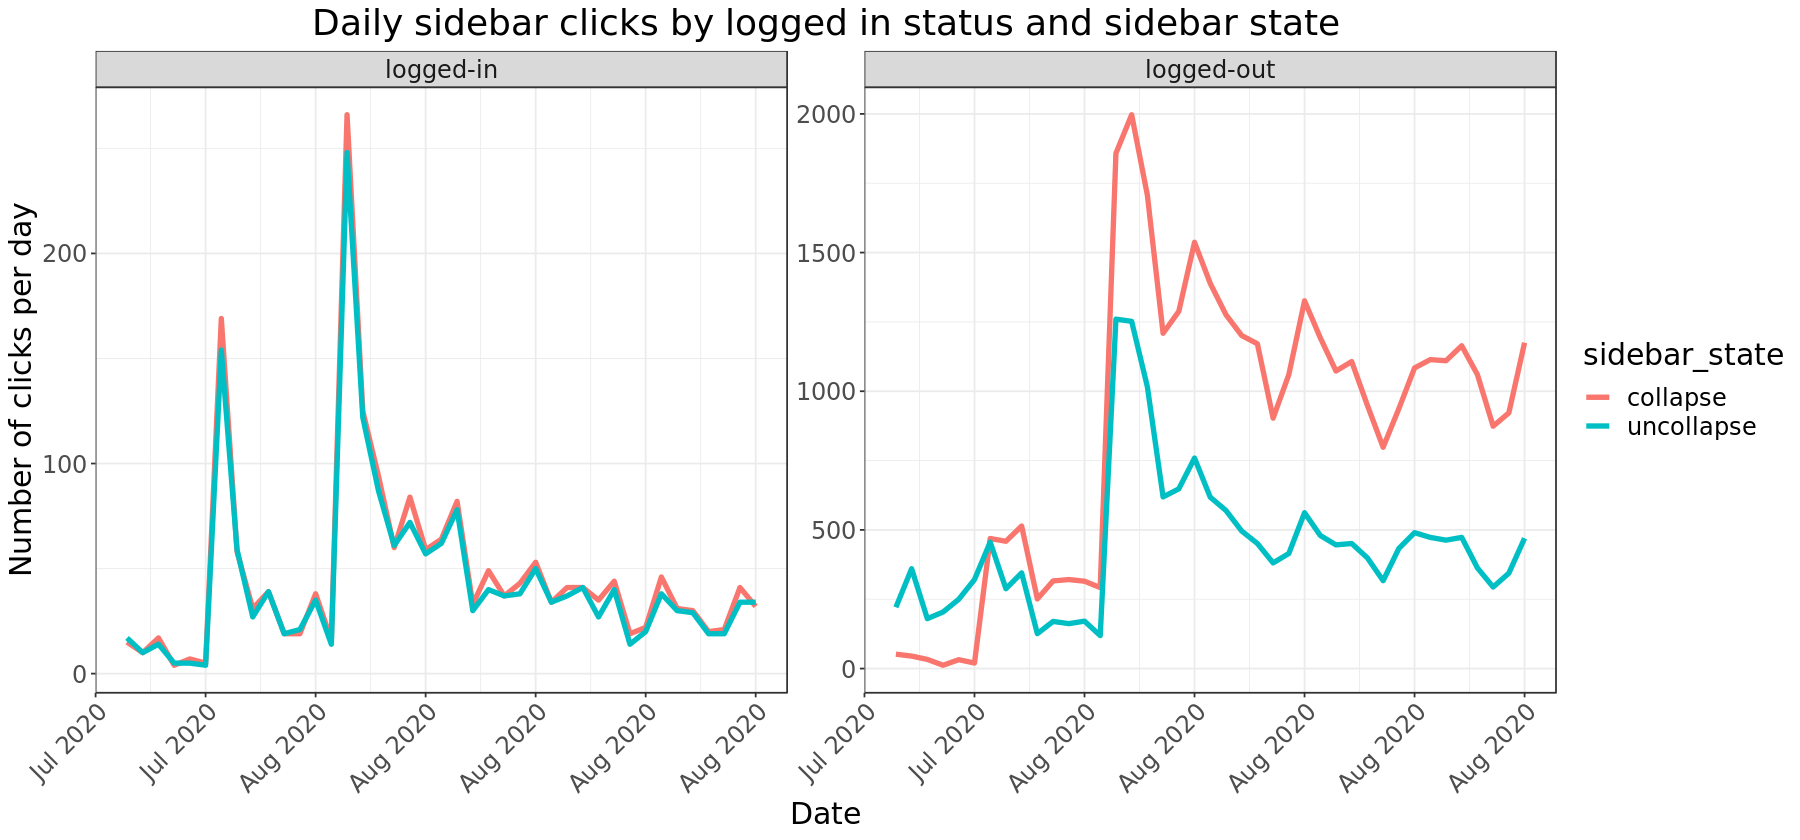

In [958]:
p <- sidebar_clicks %>%
    group_by(date, logged_in_status, sidebar_state) %>%
    summarise(total_events = sum(events)) %>%
    ggplot(aes(x = date, y= total_events, color = sidebar_state)) +
        geom_line(size = 1.5) +
        facet_wrap(~logged_in_status, scales = "free") +
        scale_x_date("Date", labels = date_format("%b %Y"), date_breaks = "1 week") +
        scale_y_continuous("Number of clicks per day") +
        labs (title = "Daily sidebar clicks by logged in status and sidebar state")  +
        theme_bw() +
        theme(
        plot.title = element_text(hjust = 0.5),,
        text = element_text(size=18),
        axis.text.x = element_text(angle = 45, hjust = 1))
p


ggsave("Figures/daily_sidebar_clicks_byloggedin_sidebarstate.png", p, width = 16, height = 8, units = "in", dpi = 300)

`summarise()` regrouping output by 'logged_in_status' (override with `.groups` argument)



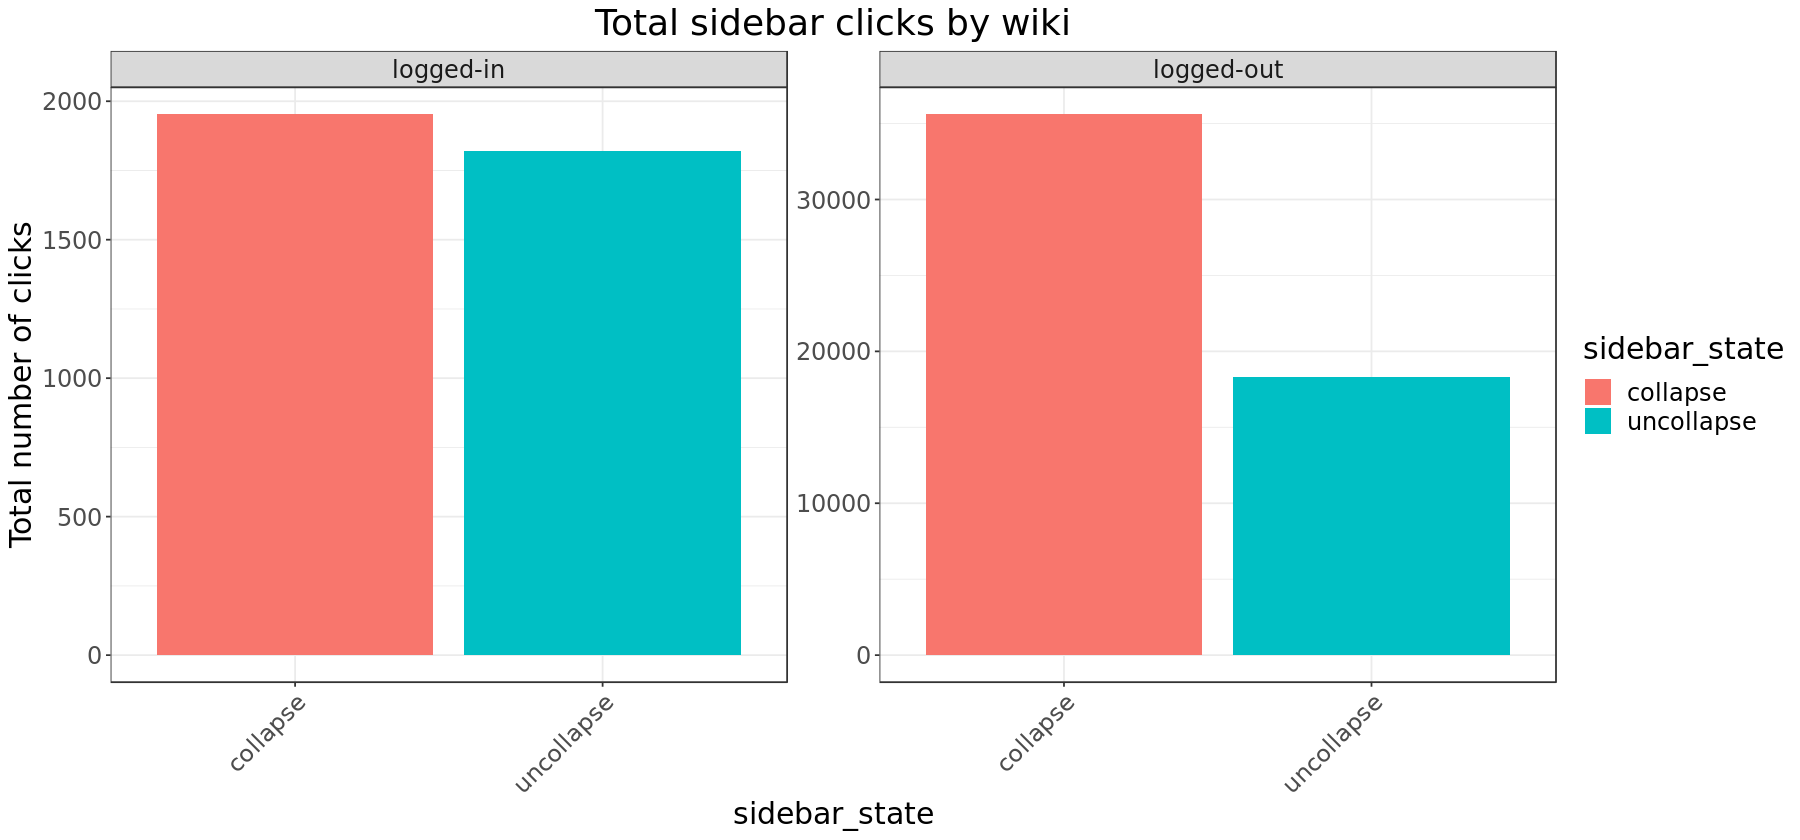

In [959]:
p <- sidebar_clicks %>%
    group_by(logged_in_status, sidebar_state) %>%
    summarise(total_events = sum(events)) %>%
    ggplot(aes(x = sidebar_state, y= total_events, fill = sidebar_state)) +
        geom_bar(stat = 'identity') +
         facet_wrap(~logged_in_status, scales = "free") +
        scale_y_continuous("Total number of clicks") +
        labs (title = "Total sidebar clicks by wiki")  +
        theme_bw() +
        theme(
        plot.title = element_text(hjust = 0.5),,
        text = element_text(size=18),
        axis.text.x = element_text(angle = 45, hjust = 1))
p

ggsave("Figures/total_sidebar_clicks_byloggedin_sidebarstate.png", p, width = 16, height = 8, units = "in", dpi = 300)

Logged-in users have a higher number of average sidebar clicks per session (2.6) compared to logged-out (1.9) (i.e. logged-in users clicks the sidebar more often on a per session basis). In addition, there is a similar number of clicks to collapse and clicks to uncollapse the sidebar for logged-in users while logged-out users have more than twice the number of collapse events compared to uncollapse events.

Since the sidebar status is preserved for logged-in users across sessions, there might be logged-in session that start off with uncollapse event that require collapsing while logged-out users will always start with an uncollapsed sidebar.


## What is the frequency of sidebar clicks in each session?

### Overall

`summarise()` ungrouping output (override with `.groups` argument)



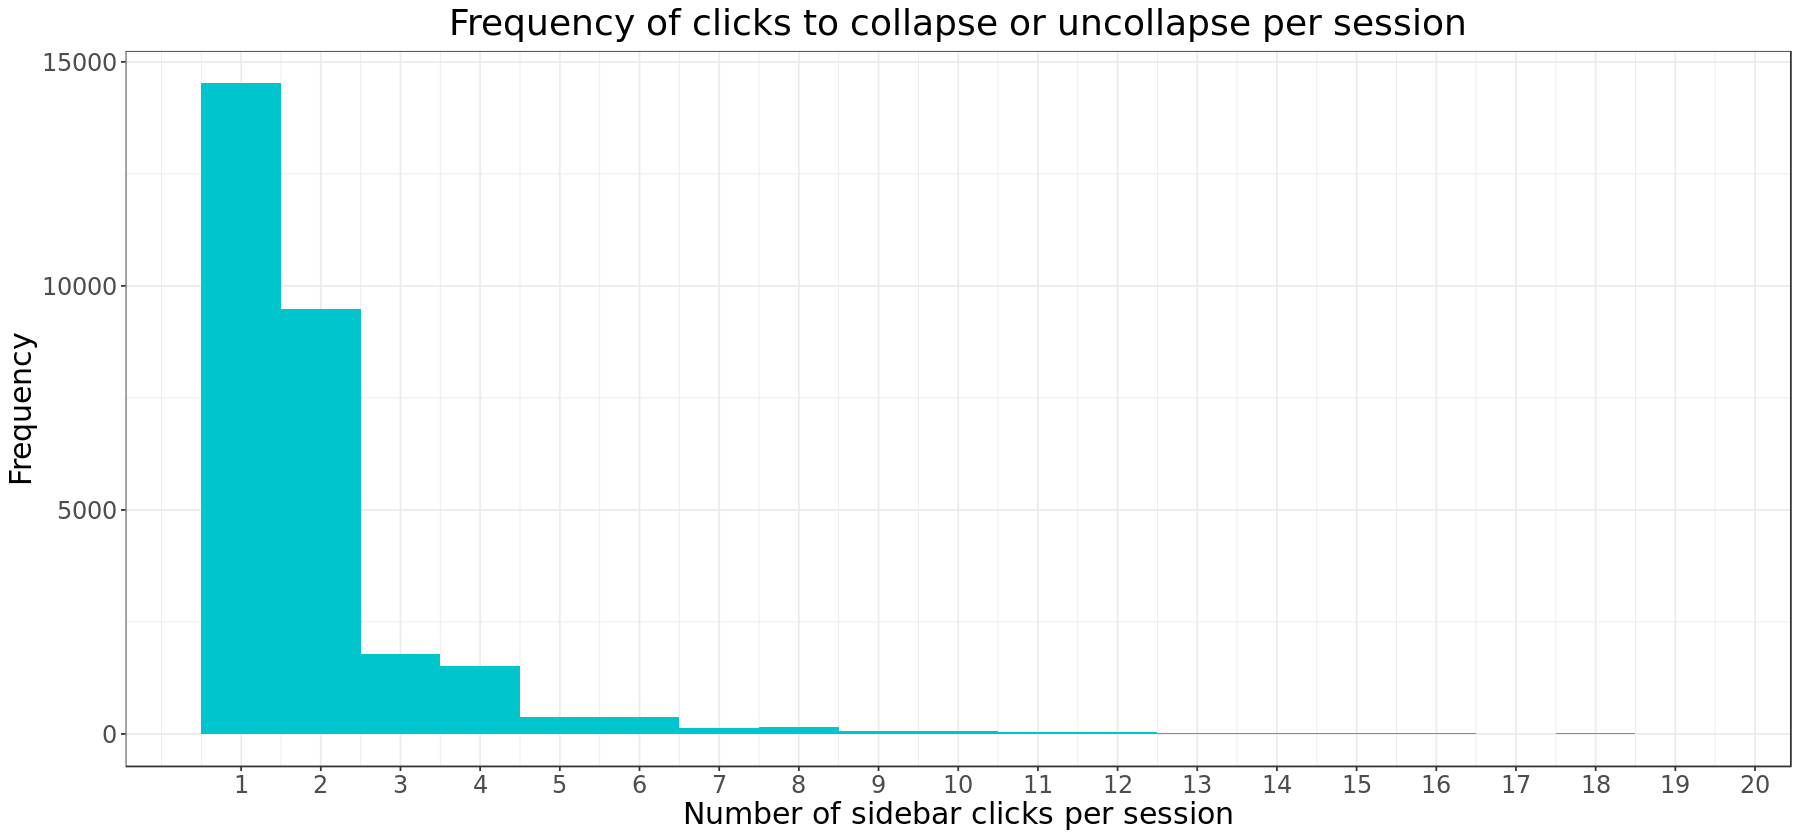

In [10]:
# Chart histogram showing frequency of clicks per session

p <- sidebar_clicks %>%
    group_by(session)%>%
    summarize(sidebar_clicks = sum(events)) %>%
# removing sessions with over 20 clicks for visibility
    filter(sidebar_clicks < 20) %>%
    ggplot(aes(x= sidebar_clicks)) +
        geom_histogram(binwidth = 1, fill = 'turquoise3') +
        scale_y_continuous("Frequency") +
        scale_x_continuous("Number of sidebar clicks per session", breaks = seq(1,20,1)) +
        labs(title = "Frequency of clicks to collapse or uncollapse per session")  +
        theme_bw() +
        theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=18)) 
p

ggsave("Figures/sidebar_click_frequency.png", p, width = 16, height = 8, units = "in", dpi = 300)

The majority of sessions have either 1 or 2 clicks to the sidebar, with most just having one. 

### By Wiki

`summarise()` regrouping output by 'session' (override with `.groups` argument)



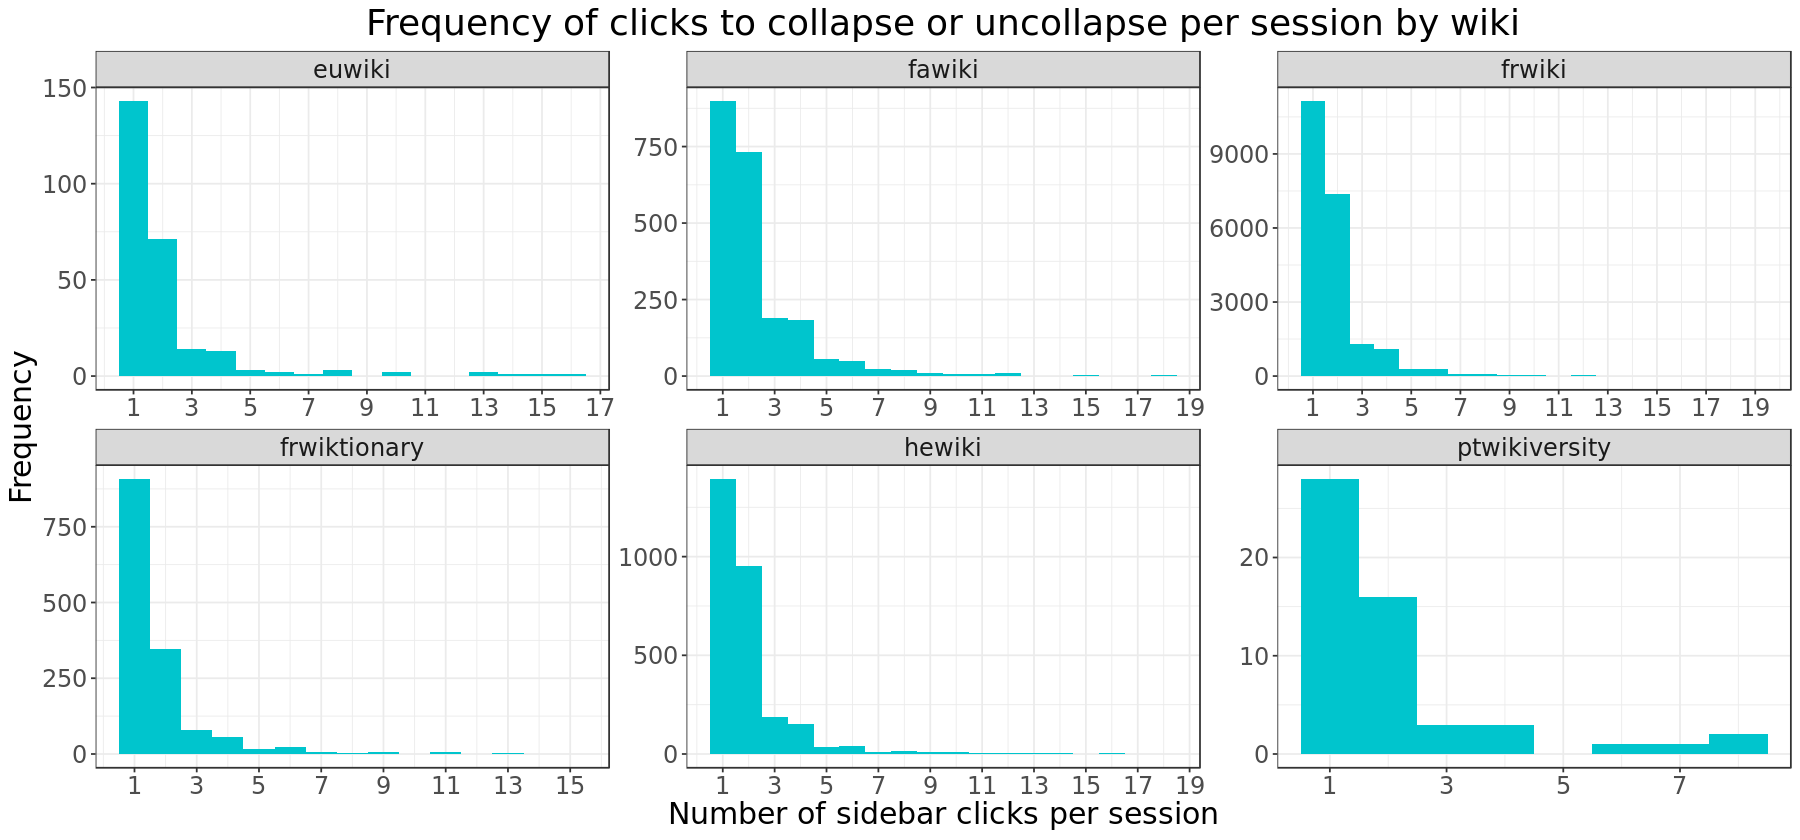

In [11]:
# Chart histogram showing frequency of clicks per session

p <- sidebar_clicks %>%
    group_by(session, wiki)%>%
    summarize(sidebar_clicks = sum(events)) %>%
# removing sessions with over 20 clicks for visibility
    filter(sidebar_clicks < 20) %>%
    ggplot(aes(x= sidebar_clicks)) +
        geom_histogram(binwidth = 1, fill = 'turquoise3') +
        facet_wrap(~wiki, scales = 'free') +
        scale_y_continuous("Frequency") +
        scale_x_continuous("Number of sidebar clicks per session", breaks = seq(1,20,2)) +
        labs(title = "Frequency of clicks to collapse or uncollapse per session by wiki")  +
        theme_bw() +
        theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=18)) 
p

ggsave("Figures/sidebar_click_frequency_bywiki.png", p, width = 16, height = 8, units = "in", dpi = 300)

Across all of the test wikis, the sidebar is clicked either once or twice most frequently in a session. French Wikipedia, Persian Wikipedia, and ptWikiversity have a higher proprtion of sessions with 2 clicks while French Wikitionary and Basque Wikipedia have the larget propotion of one click sessions.   

### User Edit Count

`summarise()` regrouping output by 'session' (override with `.groups` argument)



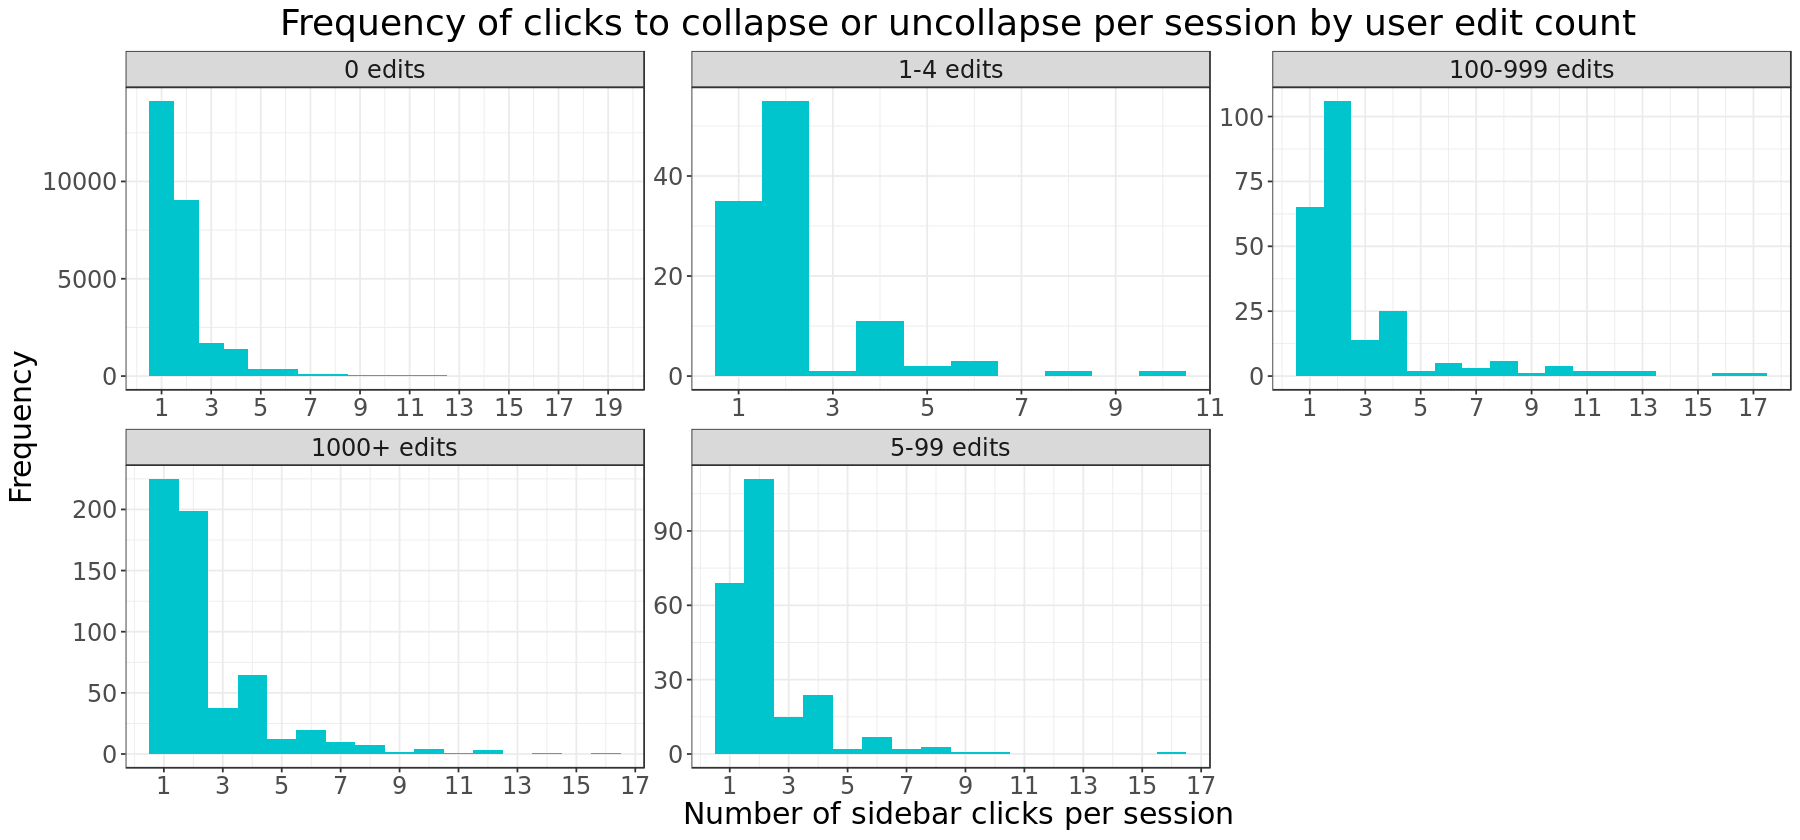

In [12]:
# Chart histogram showing frequency of clicks per session

p <- sidebar_clicks %>%
    group_by(session, user_edit_count)%>%
    summarize(sidebar_clicks = sum(events)) %>%
# removing sessions with over 20 clicks for visibility
    filter(sidebar_clicks < 20) %>%
    ggplot(aes(x= sidebar_clicks)) +
        geom_histogram(binwidth = 1, fill = 'turquoise3') +
        facet_wrap(~user_edit_count, scales = 'free') +
        scale_y_continuous("Frequency") +
        scale_x_continuous("Number of sidebar clicks per session", breaks = seq(1,20,2)) +
        labs(title = "Frequency of clicks to collapse or uncollapse per session by user edit count")  +
        theme_bw() +
        theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=18)) 
p

ggsave("Figures/sidebar_click_frequency_byeditcount.png", p, width = 16, height = 8, units = "in", dpi = 300)

Users with either 0 edits or over 1000 edits had a higher frequency of sessions with 1 click while users with edits between those two groups had a higher frequency of session with 2 clicks. 

### logged in vs logged out

`summarise()` regrouping output by 'session' (override with `.groups` argument)



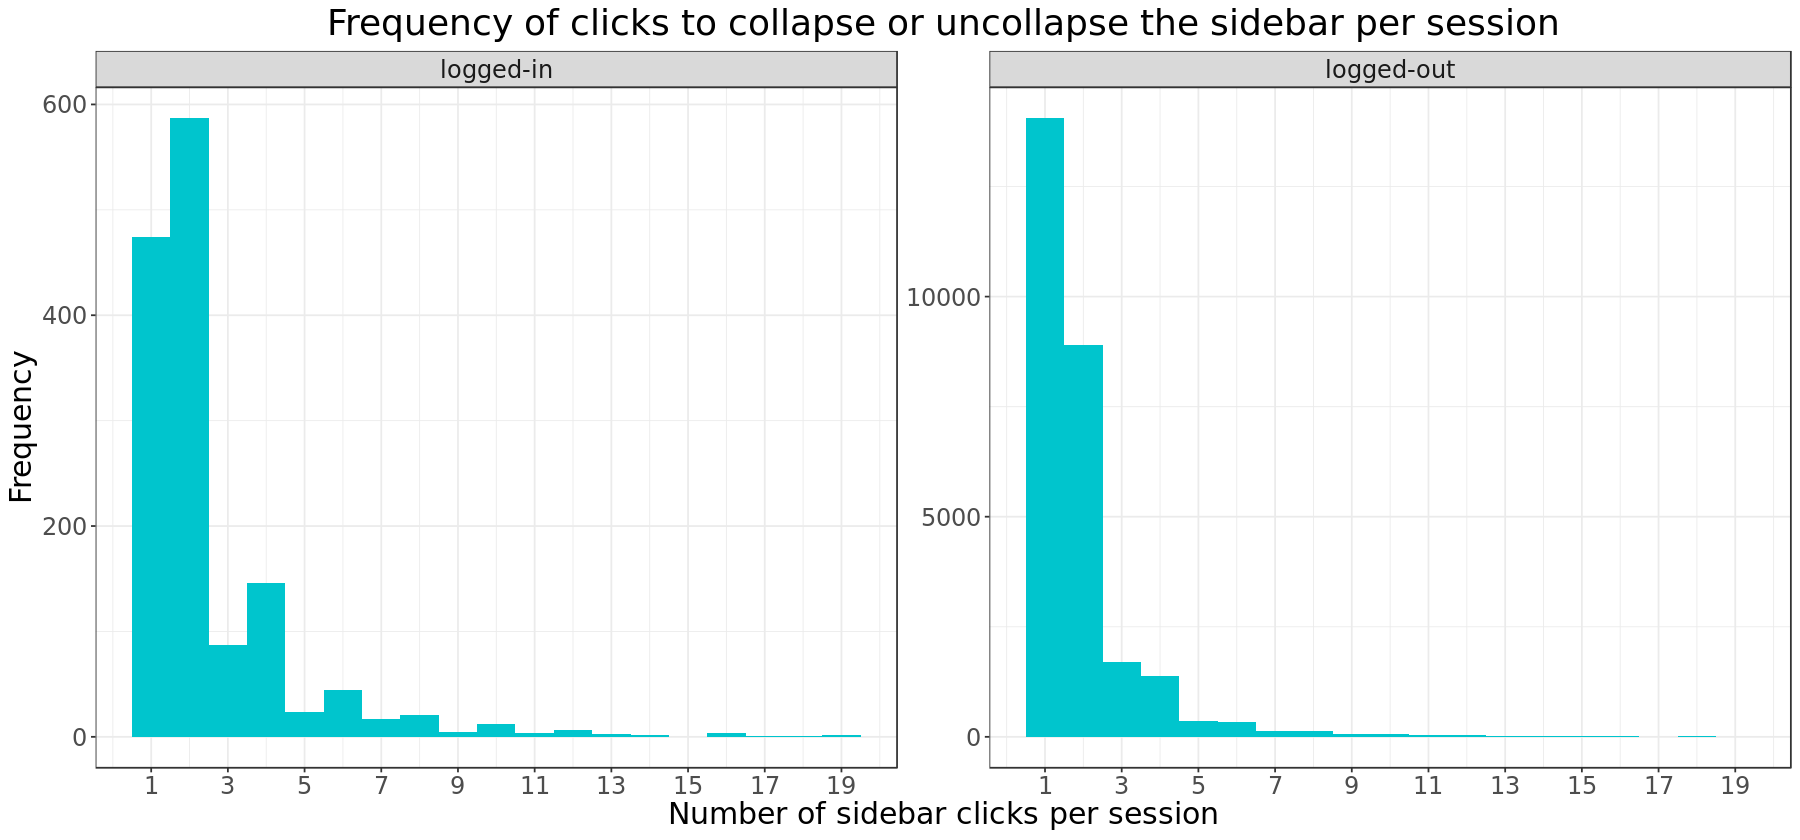

In [15]:
# Chart histogram showing frequency of clicks per session

p <- sidebar_clicks %>%
    group_by(session, logged_in_status)%>%
    summarize(sidebar_clicks = sum(events)) %>%
# removing sessions with over 20 clicks for visibility
    filter(sidebar_clicks < 20) %>%
    ggplot(aes(x= sidebar_clicks)) +
        geom_histogram(binwidth = 1, fill = 'turquoise3') +
        facet_wrap(~logged_in_status, scales = 'free') +
        scale_y_continuous("Frequency") +
        scale_x_continuous("Number of sidebar clicks per session", breaks = seq(1,20,2)) +
        labs(title = "Frequency of clicks to collapse or uncollapse the sidebar per session")  +
        theme_bw() +
        theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=18)) 
p

ggsave("Figures/sidebar_click_frequency_byloggedout.png", p, width = 16, height = 8, units = "in", dpi = 300)

Logged out users have a higher frequency of one sidebar clicks per session while logged in users have a higher frequency of 2 clicks per session.

## What percent of all sessions include a sidebar click?

In [276]:
## Count types of click events by session, wiki and edit count
query <- 
"SELECT 
    event.token AS session,
    wiki AS wiki,
    event.isAnon AS logged_in_status,
    event.editCountBucket AS user_edit_count,
    SUM(CAST(event.action = 'click' and event.name = 'ui.sidebar' AS INT)) as sidebar_click,
    SUM(CAST(event.action = 'click' AS INT)) as click_event,
    COUNT(*) all_events
FROM event.desktopwebuiactionstracking
WHERE 
    year = 2020
    AND ((month=07 AND day >= 22) OR month= 08 ) 
-- sidebar is collapsible only on new vector skin
    AND event.skinversion = 2
    AND wiki <> 'testwiki'
     AND useragent.is_bot = false
GROUP BY
    event.token,
    wiki,
    event.isAnon,
    event.editCountBucket
"

In [277]:
all_clicks <- wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [278]:
all_clicks$logged_in_status <- ifelse(all_clicks$logged_in_status == 'false', "logged-in", "logged-out")

### Overall

In [ ]:
#Counts by session

count_clicks_bysession <- all_clicks %>%
    group_by(session) %>%
    summarize(sidebar_click = sum(sidebar_click),
                 click_event = sum(click_event),
                 all_events = sum(all_events))

head(count_clicks_bysession)

In [186]:
# Percent of all sessions with at least 1 click to the sidebar 
sidebar_session_prop <- count_clicks_bysession %>%
    mutate(w_sidebar_click = ifelse(sidebar_click >= 1, 'true', 'false'),
          w_click = ifelse(click_event >= 1, 'true', 'false')) %>%
    summarize(num_sidebar_sessions = sum(w_sidebar_click == 'true'),
              num_allclick_sessions = sum(w_click == 'true'),
             num_all_sessions = n(),
              pct_click_sessions = num_sidebar_sessions/num_allclick_sessions * 100,
             pct_all_sessions = num_sidebar_sessions/num_all_sessions * 100)

head(sidebar_session_prop)


,num_sidebar_sessions,num_allclick_sessions,num_all_sessions,pct_click_sessions,pct_all_sessions
,<int>,<int>,<int>,<dbl>,<dbl>
1,28745,210348,21334942,13.66545,0.134732


Between July 22 and August 31, 2020, there were 28,745 sessions that included a click to collapse and/or uncollapse the sidebar. 0.13% of all recorded (including both init and click events) sessions and 13.67% of all sessions with a click included a click to collapse or uncollapse the sidebar. 

### By Wiki

In [968]:
#Counts by session and wiki

count_clicks_bysessionwiki <- all_clicks %>%
    group_by(session, wiki) %>%
    summarize(sidebar_click = sum(sidebar_click),
                 click_event = sum(click_event),
                 all_events = sum(all_events))


`summarise()` regrouping output by 'session' (override with `.groups` argument)



In [971]:
# Percent of all sessions with at least 1 click to the sidebar by wiki
sidebar_session_prop_bywiki <- count_clicks_bysessionwiki %>%
    mutate(w_sidebar_click = ifelse(sidebar_click >= 1, 'true', 'false'),
          w_click = ifelse(click_event >= 1, 'true', 'false')) %>%
    group_by(wiki) %>%
    summarize(num_sessions_wsidebarclick = sum(w_sidebar_click == 'true'),
              num_sessions_wclick = sum(w_click == 'true'),
             num_all_sessions = n(),
              pct_sidebarclick_of_allclick_sessions = num_sessions_wsidebarclick /num_sessions_wclick  * 100,
             pct_sidebarclick_of_all_sessions = num_sessions_wsidebarclick/num_all_sessions * 100)

sidebar_session_prop_bywiki

`summarise()` ungrouping output (override with `.groups` argument)



wiki,num_sessions_wsidebarclick,num_sessions_wclick,num_all_sessions,pct_sidebarclick_of_allclick_sessions,pct_sidebarclick_of_all_sessions
<chr>,<int>,<int>,<int>,<dbl>,<dbl>
euwiki,260,1656,33823,15.700483,0.76870768
fawiki,2223,32835,2564847,6.770215,0.08667184
frwiki,21902,138775,16351720,15.782382,0.13394310
frwiktionary,1458,5246,730118,27.792604,0.19969375
hewiki,2826,25238,1622447,11.197401,0.17418134
ptwikiversity,54,263,10108,20.532319,0.53423031


Frwikitionary had the highest percentage of sessions with sidebar clicks (0.2% of all sessions with a click) and Persian Wikipedia had the lowest percentage of sessions with sidebar clicks (0.09% of all sessions)

### By User Edit Count

In [973]:
#Counts by session and user edit count

count_clicks_bysession_editcount <- all_clicks %>%
# remove logged out users
    filter(logged_in_status == 'logged-in') %>%
    group_by(session, user_edit_count) %>%
    summarize(sidebar_click = sum(sidebar_click),
                 click_event = sum(click_event),
                 all_events = sum(all_events))


`summarise()` regrouping output by 'session' (override with `.groups` argument)



In [974]:
# Percent of all sessions with at least 1 click to the sidebar by user edit count
sidebar_session_prop_byeditcount <- count_clicks_bysession_editcount %>%
    mutate(w_sidebar_click = ifelse(sidebar_click >= 1, 'true', 'false'),
          w_click = ifelse(click_event >= 1, 'true', 'false')) %>%
    group_by(user_edit_count) %>%
 summarize(num_sessions_wsidebarclick = sum(w_sidebar_click == 'true'),
              num_sessions_wclick = sum(w_click == 'true'),
             num_all_sessions = n(),
              pct_sidebarclick_of_allclick_sessions = num_sessions_wsidebarclick /num_sessions_wclick  * 100,
             pct_sidebarclick_of_all_sessions = num_sessions_wsidebarclick/num_all_sessions * 100)

head(sidebar_session_prop_byeditcount)

`summarise()` ungrouping output (override with `.groups` argument)



user_edit_count,num_sessions_wsidebarclick,num_sessions_wclick,num_all_sessions,pct_sidebarclick_of_allclick_sessions,pct_sidebarclick_of_all_sessions
<chr>,<int>,<int>,<int>,<dbl>,<dbl>
0 edits,270,4160,24802,6.490385,1.0886219
1-4 edits,109,3461,13886,3.149379,0.7849633
100-999 edits,239,6973,23165,3.427506,1.0317289
1000+ edits,591,21776,42904,2.713997,1.3774939
5-99 edits,237,6756,28719,3.507993,0.8252376


Users with 0 edits had the highest percentage of sessions with sidebar clicks (1.09% of all sessions) and users with 1-4 edits had the lowest percentage of sessions with sidebar clicks (0.78%).  

Users with over 1000 edits had the lowest percentage of sessions with sidebar clicks out of all sessions that included a click. 

### Logged In Status

In [975]:
#Counts by session and user edit count

count_clicks_bysession_isanon <- all_clicks %>%
    group_by(session, logged_in_status) %>%
    summarize(sidebar_click = sum(sidebar_click),
                 click_event = sum(click_event),
                 all_events = sum(all_events))


`summarise()` regrouping output by 'session' (override with `.groups` argument)



In [978]:
# Percent of all sessions with at least 1 click to the sidebar by logged in status
sidebar_session_prop_byloggedstate <- count_clicks_bysession_isanon %>%
    mutate(w_sidebar_click = ifelse(sidebar_click >= 1, 'true', 'false'),
          w_click = ifelse(click_event >= 1, 'true', 'false')) %>%
    group_by(logged_in_status) %>%
     summarize(num_sessions_wsidebarclick = sum(w_sidebar_click == 'true'),
              num_sessions_wclick = sum(w_click == 'true'),
             num_all_sessions = n(),
              pct_sidebarclick_of_allclick_sessions = num_sessions_wsidebarclick /num_sessions_wclick  * 100,
             pct_sidebarclick_of_all_sessions = num_sessions_wsidebarclick/num_all_sessions * 100)

head(sidebar_session_prop_byloggedstate)

`summarise()` ungrouping output (override with `.groups` argument)



logged_in_status,num_sessions_wsidebarclick,num_sessions_wclick,num_all_sessions,pct_sidebarclick_of_allclick_sessions,pct_sidebarclick_of_all_sessions
<chr>,<int>,<int>,<int>,<dbl>,<dbl>
logged-in,1445,41710,129086,3.464397,1.1194088
logged-out,27301,168302,21208091,16.221435,0.1287292


When looking at only sessions that included a click action, logged out users had the highest percentage of sessions with sidebar clicks (16.2% of all click sessions).

However, when looking at all sessions including both init and click actions, logged out users had a lower percentage of sessions with sidebar clicks (0.13% of all sessions).

# What are the different interaction types with the sidebar?

## Approach

- Identify session length for when the sidebar was collapsed or uncollapsed by finding the time the sidebar was collapsed and/or uncollapsed and the total session length for each session using the DesktopWebUIActions schema. 
- Review the different interaction types with the sidebar for each session. (i.e. was the sidebar open or closed the majority of the time?, Did users typically uncollapse the sidebar after collapsing?). 
- Note: "Sidebar click" is defined as a click to collapse or uncollapse the sidebar in the analysis below.



In [16]:
# Find session length and sidebar click time for all modern vector skin sessions

query <- 
"
WITH start_session AS (
SELECT
    event.token AS session,
    wiki,
    MIN(dt) AS session_start_ts
FROM event.desktopwebuiactionstracking
WHERE 
    year = 2020
      AND ((month=07 AND day >= 22) OR month= 08 ) 
-- sidebar is collapsible only on new vector skin
    AND event.skinversion = 2
    AND wiki <> 'testwiki'
    AND useragent.is_bot = false
GROUP BY
    event.token,
    wiki
),

end_session AS (
SELECT
    event.token AS session,
    wiki,
    MAX(dt) AS session_end_ts
FROM event.desktopwebuiactionstracking
WHERE 
    year = 2020
      AND ((month=07 AND day >= 22) OR month= 08 ) 
-- sidebar is collapsible only on new vector skin
    AND event.skinversion = 2
    AND wiki <> 'testwiki'
    AND useragent.is_bot = false
GROUP BY
    event.token,
    wiki
),

uncollapse_click_event AS (
SELECT
    event.token AS session,
    wiki,
    dt AS uncollapse_click_ts
FROM event.desktopwebuiactionstracking
WHERE 
-- review clicks to the sidebar
    event.name = 'ui.sidebar' 
    AND event.action = 'click'
    AND event.isSidebarCollapsed = false
    AND year = 2020
     AND ((month=07 AND day >= 22) OR month= 08 ) 
-- sidebar is collapsible only on new vector skin
    AND event.skinversion = 2
    AND wiki <> 'testwiki'
    AND useragent.is_bot = false
),

collapse_click_event AS (
SELECT
    event.token AS session,
    wiki,
    dt AS collapse_click_ts
FROM event.desktopwebuiactionstracking
WHERE 
-- review clicks to the sidebar
    event.name = 'ui.sidebar' 
    AND event.action = 'click'
    AND event.isSidebarCollapsed = true
    AND year = 2020
     AND ((month=07 AND day >= 22) OR month= 08 ) 
-- sidebar is collapsible only on new vector skin
    AND event.skinversion = 2
    AND wiki <> 'testwiki'
    AND useragent.is_bot = false
)

SELECT 
    start_session.session, 
    start_session.wiki,
    start_session.session_start_ts,
    end_session.session_end_ts,
    collapse_click_event.collapse_click_ts,
    uncollapse_click_event.uncollapse_click_ts
FROM start_session
JOIN end_session
    ON start_session.session = end_session.session AND
    start_session.wiki = end_session.wiki
LEFT JOIN collapse_click_event
ON start_session.session = collapse_click_event.session AND
    start_session.wiki = collapse_click_event.wiki
LEFT JOIN uncollapse_click_event
ON start_session.session = uncollapse_click_event.session AND
    start_session.wiki = uncollapse_click_event.wiki
"

In [17]:
sidebar_session_info <- wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [18]:
# Calculate session lengths
session_lengths <- sidebar_session_info %>%
    mutate(
        session_start = ymd_hms(session_start_ts),
        session_end = ymd_hms(session_end_ts),
        collapse_click_length_time = ymd_hms(collapse_click_ts) - session_start,
        session_length = session_end - session_start ,
        incl_sidebar_click = ifelse(collapse_click_ts != 'NULL' | uncollapse_click_ts != 'NULL', 1, 0 )) %>%
    group_by(session) %>%
#some sessions recorded multiple times because it was collapsed and uncollapsed multiple times
    mutate(total_sidebar_events = sum(incl_sidebar_click)) %>%
    ungroup()


Warning message:
“Problem with `mutate()` input `collapse_click_length_time`.
ℹ  21286167 failed to parse.
ℹ Input `collapse_click_length_time` is `ymd_hms(collapse_click_ts) - session_start`.”
Warning message:
“ 21286167 failed to parse.”


In [19]:
# Count all sessions with a sidebar_click
count_sessions_sidebar_click <- session_lengths %>%
    filter(incl_sidebar_click == 1) %>%
    summarise(num_sidebar_click_sessions = n_distinct(session))

count_sessions_sidebar_click

num_sidebar_click_sessions
<int>
28723


## What percent of sessions collapse and uncollapse the sidebar multiple times each?


In [20]:
sidebar_multiple_event_session <- session_lengths %>%
# review sessions with multiple sidebar events. Sidebar event defined as collapsing and uncollapsing multiple times.
    filter(total_sidebar_events > 1) %>%
     summarize(multiple_event_sessions = n_distinct(session))
 sidebar_multiple_event_session   

multiple_event_sessions
<int>
5204


## What percent of sessions have the sidebar collapsed vs uncollapsed the majority of the time? 

In [918]:
sidebar_collapsed_prop <- session_lengths %>%
# review sessions where the sidebar was collapsed just once.
    filter(collapse_click_ts != 'NULL',
            uncollapse_click_ts == 'NULL',
         session_length != 0,
          total_sidebar_events == 1) %>%
## if sidebar was collapsed less than halfway through session that it was collapsed majority of the time
    mutate(collapsed_time = ifelse(collapse_click_length_time/as.double(session_length, units = 'secs') <= 0.5, "majority collapsed", "majority uncollapsed")) %>%
     summarize(num_sessions = n_distinct(session),
          pct_majority_collapsed = sum(collapsed_time == 'majority collapsed')/num_sessions * 100,
          pct_majority_uncollapsed = sum(collapsed_time == 'majority uncollapsed')/num_sessions * 100)
        
head(sidebar_collapsed_prop)

num_sessions,pct_majority_collapsed,pct_majority_uncollapsed
<int>,<dbl>,<dbl>
8791,34.5467,65.4533


For sessions where the sidebar was collapsed only once, 34.5% sessions kept the sidebar collapsed the majority of their session time and 65.4% of sessions had the sidebar uncollapsed the majority of their session time (did not collapse it until towards the end of their session).  Note: This does not include people who may have both collapsed and uncollapsed the sidebar mutliple times in a session. 

In [909]:
sidebar_collapsed_prop_bywiki <- session_lengths %>%
# review sessions where the sidebar was collapsed just once.
    filter(collapse_click_ts != 'NULL',
            uncollapse_click_ts == 'NULL',
         session_length != 0,
          total_sidebar_events == 1) %>%
## if sidebar was collapsed less than halfway through session that it was collapsed majority of the time
    mutate(collapsed_time = ifelse(collapse_click_length_time/as.double(session_length, units = 'secs') <= 0.5, "majority collapsed", "majority uncollapsed")) %>%
    group_by(wiki) %>%
     summarize(num_sessions = n_distinct(session),
          prop_majority_collapsed = sum(collapsed_time == 'majority collapsed')/num_sessions *100,
          prop_majority_uncollapsed = sum(collapsed_time == 'majority uncollapsed')/num_sessions * 100)
        
head(sidebar_collapsed_prop_bywiki)

`summarise()` ungrouping output (override with `.groups` argument)



wiki,num_sessions,prop_majority_collapsed,prop_majority_uncollapsed
<chr>,<int>,<dbl>,<dbl>
euwiki,16,31.25000,68.75000
fawiki,586,31.74061,68.25939
frwiki,7093,34.75257,65.24743
frwiktionary,226,25.66372,74.33628
hewiki,857,37.10618,62.89382
ptwikiversity,13,38.46154,61.53846


**Sidebar Interactions Summary**

|Session Behavior | Num_sessions | Percent of sessions with click to collapse and/or uncollapse
|------|-----------|------------|
|  Collapse but don't uncollapse    |   13475    | 46.91%   |     
|  Uncollapse but don't collapse   |   1043  |      3.63%  |
|  Collapse once and then uncollapse once [1]  | 242  | 0.84%|     
|  Uncollapse once and then collapse once [1]  |  26   | 0.09% | 
|  Both Collapse and Uncollapse under 1 second |  8733   |30.40% |
|  Collapse and/or Uncollapse multiple times within a session |  5204  |18.12% |

[1] Events were greater than 1 second apart

18.12% of all sessions with a sidebar click included mutiple collapse and multiple uncollapse events (i.e. the sidebar was collapsed more than once and/or uncollapsed more than once). For the majority of sessions (81.88%), the sidebar was collapsed and/or uncollapsed just once.

46.91% of sessions collapse the sidebar and then don't interact with it again. Only 0.84% of sessions collapse the sidebar and then uncollapse. In 30.40% of sesssions, the sidebar was collapsed and uncollapsed in under 1 second. These might be users quickly testing the feature.

Please see analysis below to see details regarding how the above numbers were calculated.

## What percent of sessions uncollapse the sidebar after collapsing?

In [911]:
#count sessions where a collapse event was followed by uncollapse event
session_collapse_then_uncollapse <- session_lengths %>%
    filter(total_sidebar_events == 1,
           uncollapse_click_ts != 'NULL',
           collapse_click_ts != 'NULL',
          uncollapse_click_ts > collapse_click_ts) %>%
    summarize(session_collapse_then_uncollapse = n_distinct(session))

head(session_collapse_then_uncollapse)

session_collapse_then_uncollapse
<int>
242


## What percent of sessions collapse the sidebar after uncollapsing?

In [912]:
#count sessions where a uncollapse event was followed by collapse event
session_uncollapse_then_collapse <- session_lengths %>%
    filter(total_sidebar_events == 1,
        uncollapse_click_ts != 'NULL',
           collapse_click_ts != 'NULL',
          uncollapse_click_ts < collapse_click_ts) %>%
    summarize(session_collapse_then_uncollapse = n_distinct(session))

head(session_uncollapse_then_collapse)

session_collapse_then_uncollapse
<int>
26


## What percent of sessions don't uncollapse after collapsing ?

In [913]:
session_collapse_only_frequency <- session_lengths %>%
    filter(total_sidebar_events == 1,
        uncollapse_click_ts == 'NULL',
           collapse_click_ts != 'NULL') %>%
    summarize(session_collapse_only = n_distinct(session))

head(session_collapse_only_frequency)

session_collapse_only
<int>
13475


About 49.1% of sessions collapse the sidebar in a session and then do not uncollapse it again. 

## What percent of sessions don't collapse after uncollapsing ?

In [914]:
session_uncollapse_only_frequency <- session_lengths %>%
    filter(total_sidebar_events == 1,
        uncollapse_click_ts != 'NULL',
           collapse_click_ts == 'NULL') %>%
    summarize(session_uncollapse_only = n_distinct(session))

head(session_uncollapse_only_frequency)

session_uncollapse_only
<int>
1043


## What percent of sessions collapse and uncollapse within 1 second of each other?

In [915]:
session_collapse_uncollapse_sametime <- session_lengths %>%
    filter(total_sidebar_events == 1,
        uncollapse_click_ts != 'NULL',
           collapse_click_ts != 'NULL',
          uncollapse_click_ts == collapse_click_ts) %>%
    summarize(session_collapse_uncollapse_sametime = n_distinct(session))

head(session_collapse_uncollapse_sametime)

session_collapse_uncollapse_sametime
<int>
8733


# What is the overall difference in interaction with sidebar links before and after the change?


## Approach
- Compare interactions with the sidebar link for both vector skin versions (legacy and modern) with a specific focus on the impact to donate link. Since this was deployed as opt-out to the reviewed wikis, there is not a random, equal split of users between the two groups so a direct comparison cannot be made as there may be some bias (the legacy skin version was only available to those that explicilty opt'd out) and also there more users that had the default experience. However, we can compare the average interactions per session to control for the different number of users.
- I also reviewed the total number of clicks to the sidebar links for two week period before and after change for each wiki 
- Assuming that all sidebar links are recorded as "n-" in the data.

## How do the sidebar events per session compare for each skin type?

In [21]:
query <- 
"
SELECT
    date_format(dt, 'yyyy-MM-dd') AS date,
    event.token as session,
    event.skinversion,
    wiki AS wiki,
    event.isAnon AS logged_in_status,
    event.editCountBucket AS user_edit_count,
    event.name AS name,
    COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
    year = 2020
    AND((month=07 AND day >= 22) OR month= 08 ) 
    AND wiki <> 'testwiki'
  --- only reviewing clicks to sidebarlinks
    AND event.action = 'click'
    AND useragent.is_bot = false
    AND event.name LIKE 'n-%'
GROUP BY 
    date_format(dt, 'yyyy-MM-dd'),
    event.token,
    event.skinversion,
    wiki,
    event.isAnon,
    event.editCountBucket,
    event.name
"


In [22]:
sidebar_link_interactions <- wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [23]:
sidebar_link_interactions$skinversion <- ifelse(sidebar_link_interactions$skinversion == '1', "legacy", "modern")

In [24]:
sidebar_link_interactions$logged_in_status <- ifelse(sidebar_link_interactions$logged_in_status == 'false', "logged-in", "logged-out")

In [25]:
sidebar_link_interactions$skinversion <- as.factor(sidebar_link_interactions$skinversion)

In [541]:
# query to find percent of sessions with a sidebar link click
query <- 
"
SELECT
    date_format(dt, 'yyyy-MM-dd') AS date,
    event.token as session,
    event.skinversion,
    wiki AS wiki,
    event.isAnon AS logged_in_status,
    event.editCountBucket AS user_edit_count,
    event.name AS name,
    SUM(CAST(event.action = 'click' AND event.name LIKE 'n-%' AS INT)) AS sidebar_link_click
FROM event.desktopwebuiactionstracking
WHERE
    year = 2020
    AND((month=07 AND day >= 22) OR month= 08 ) 
    AND wiki IN ('euwiki', 'fawiki', 'frwiki', 'frwiktionary', 'hewiki', 'ptwikiversity')
    AND useragent.is_bot = false
GROUP BY 
    date_format(dt, 'yyyy-MM-dd'),
    event.token,
    event.skinversion,
    wiki,
    event.isAnon,
    event.editCountBucket,
    event.name
"


In [542]:
sidebar_link_clicks <- wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [543]:
sidebar_link_clicks$skinversion <- ifelse(sidebar_link_clicks$skinversion == '1', "legacy", "modern")

In [544]:
sidebar_link_clicks$logged_in_status <- ifelse(sidebar_link_clicks$logged_in_status == 'false', "logged-in", "logged-out")

In [545]:
sidebar_link_clicks$skinversion <- as.factor(sidebar_link_clicks$skinversion)

### Overall

#### Average events per session by skin type

In [1009]:
sidebarlink_clicks_persession <- sidebar_link_interactions %>%
    group_by(skinversion) %>%
    summarize(total_events = sum(events),
              unique_sessions = n_distinct(session),
              avg_events_persession = total_events/unique_sessions)  %>%
    arrange(desc(total_events))

head(sidebarlink_clicks_persession)


`summarise()` ungrouping output (override with `.groups` argument)



skinversion,total_events,unique_sessions,avg_events_persession
<chr>,<int>,<int>,<dbl>
modern,166826,46004,3.626337
legacy,70515,15070,4.679164


The legacy skin has a slightly higher number of events per session (4.68) compared to modern (3.63)

#### Average events per session by skin type and event name

In [1010]:
## Average events per session by skin type and event name

sidebarlink_clicks_persession_byname <- sidebar_link_interactions %>%
    group_by(skinversion, name) %>%
    summarize(total_events = sum(events),
              unique_sessions = n_distinct(session),
              avg_events_persession = total_events/unique_sessions)  %>%
    arrange(desc(total_events))


`summarise()` regrouping output by 'skinversion' (override with `.groups` argument)



In [472]:
top_20_sidebarlinks <- sidebarlink_clicks_persession_byname %>%
    group_by(skinversion) %>%
 slice_max(total_events, n=10)

top_20_sidebarlinks

skinversion,name,total_events,unique_sessions,avg_events
<fct>,<chr>,<int>,<int>,<dbl>
legacy,n-randompage,53138,6062,8.765754
legacy,n-recentchanges,8727,3072,2.840820
legacy,n-mainpage-description,3652,3187,1.145905
legacy,n-portal,1017,762,1.334646
legacy,n-thema,908,833,1.090036
legacy,n-bistro,599,204,2.936275
legacy,n-contact,500,481,1.039501
legacy,n-aboutwp,478,438,1.091324
legacy,n-mainpage,236,184,1.282609


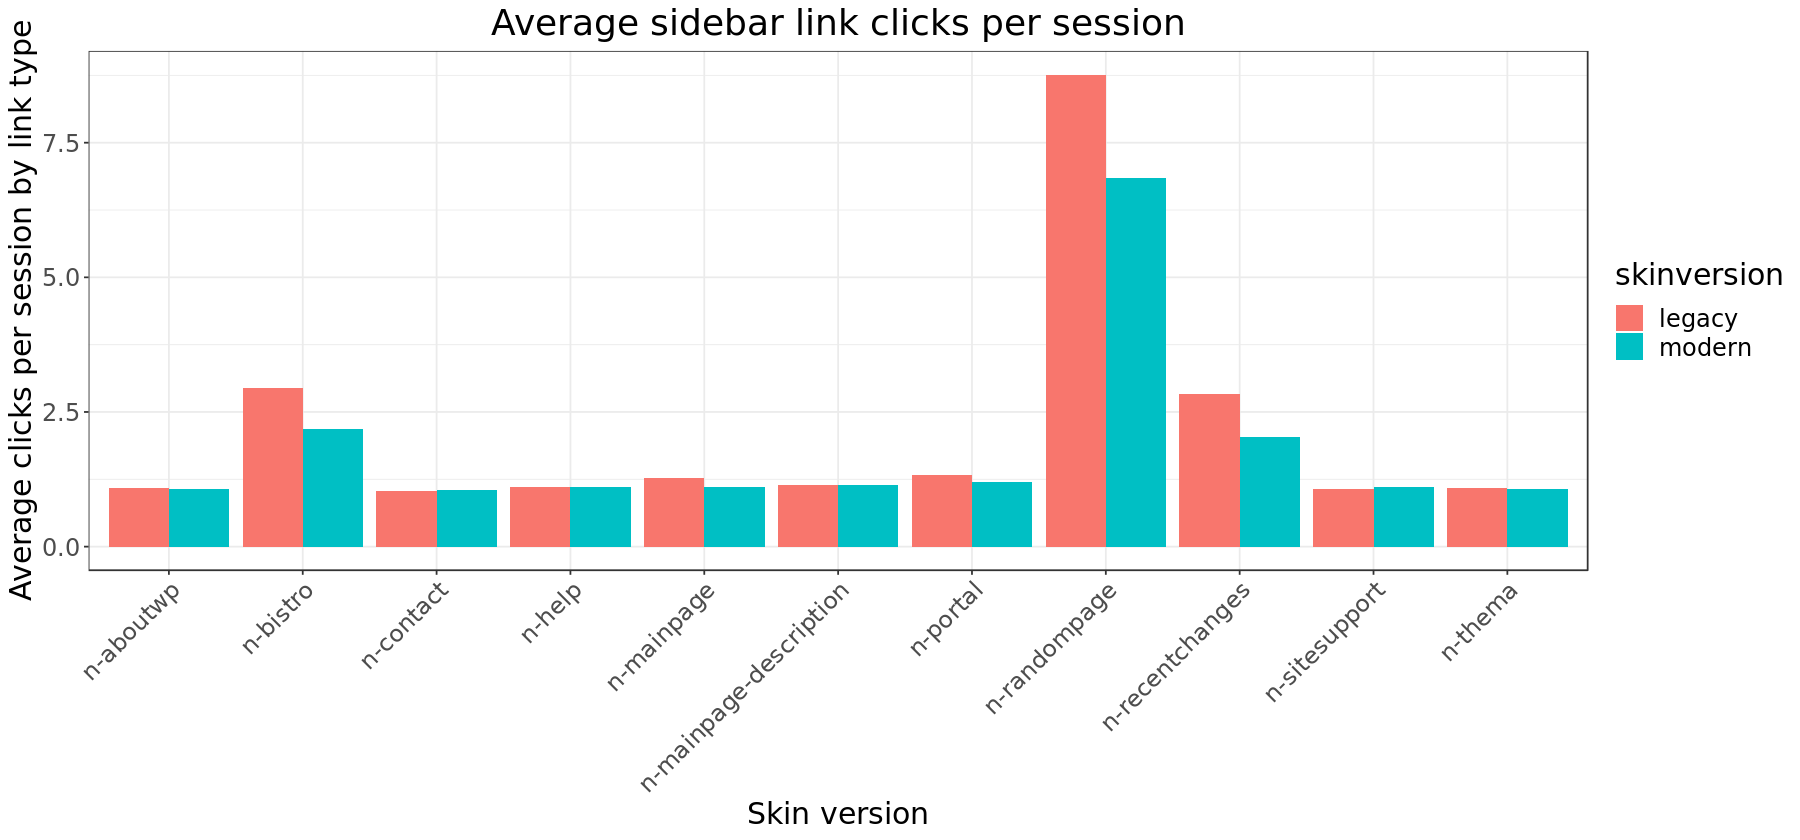

In [981]:
p <- sidebarlink_clicks_persession_byname %>%
    filter(name %in% top_20_sidebarlinks$name) %>%
    ggplot(aes(x=name, y = avg_events, fill = skinversion)) +
    geom_col(position = 'dodge') +
        scale_y_continuous("Average clicks per session by link type") +
        scale_x_discrete("Skin version") +
        labs(title = "Average sidebar link clicks per session")  +
        theme_bw() +
        theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=18),
        axis.text.x = element_text(angle = 45, hjust = 1)) 
p


ggsave("Figures/average_sidebar_link_events.png", p, width = 16, height = 8, units = "in", dpi = 300)

The averarge sidebar link clicks per session are similar for both legacy and modern for most of the commonly clicked links. 

There is a slightly higher average clicks per session on legacy to the random page, recent changes, and community portal (bistro).

For the donate link, there is a slightly higher number of average clicks per session on the modern skin compared to the legacy skin. 

### What percent of sessions include a click to the sidebar link?

In [982]:
sidebar_link_click_sessions <- sidebar_link_clicks %>%
    group_by(skinversion) %>%
    summarise(num_sessions = n_distinct(session),
             sessions_w_linkclick = sum(sidebar_link_click > 0),
             pct_sessions_wlinkclick = sessions_w_linkclick/num_sessions *100 )

sidebar_link_click_sessions

`summarise()` ungrouping output (override with `.groups` argument)



skinversion,num_sessions,sessions_w_linkclick,pct_sessions_wlinkclick
<fct>,<int>,<int>,<dbl>
legacy,6059922,17580,0.2901027
modern,21313061,51533,0.2417907


The legacy skin has only a slightly higher percent of sessions that include a click to any one of the sidebar links compared to modern (0.29% vs 0.24%)

## By Wiki

#### Average events per session by wiki and skin type

In [983]:
## Average events per session by wiki and skin type

sidebarlink_clicks_persession_bywiki <- sidebar_link_interactions %>%
    group_by(wiki, skinversion) %>%
    summarize(total_events = sum(events),
              unique_sessions = n_distinct(session),
              avg_events_persession = total_events/unique_sessions)  %>%
    arrange(desc(wiki))

sidebarlink_clicks_persession_bywiki

`summarise()` regrouping output by 'wiki' (override with `.groups` argument)



wiki,skinversion,total_events,unique_sessions,avg_events_persession
<chr>,<chr>,<int>,<int>,<dbl>
ptwikiversity,legacy,5,3,1.666667
ptwikiversity,modern,178,96,1.854167
hewiki,legacy,8034,1831,4.387766
hewiki,modern,19357,5578,3.470240
frwiktionary,legacy,493,191,2.581152
frwiktionary,modern,3464,1288,2.689441
frwiki,legacy,59094,12013,4.919171
frwiki,modern,131288,32662,4.019595
fawiki,legacy,2871,1023,2.806452


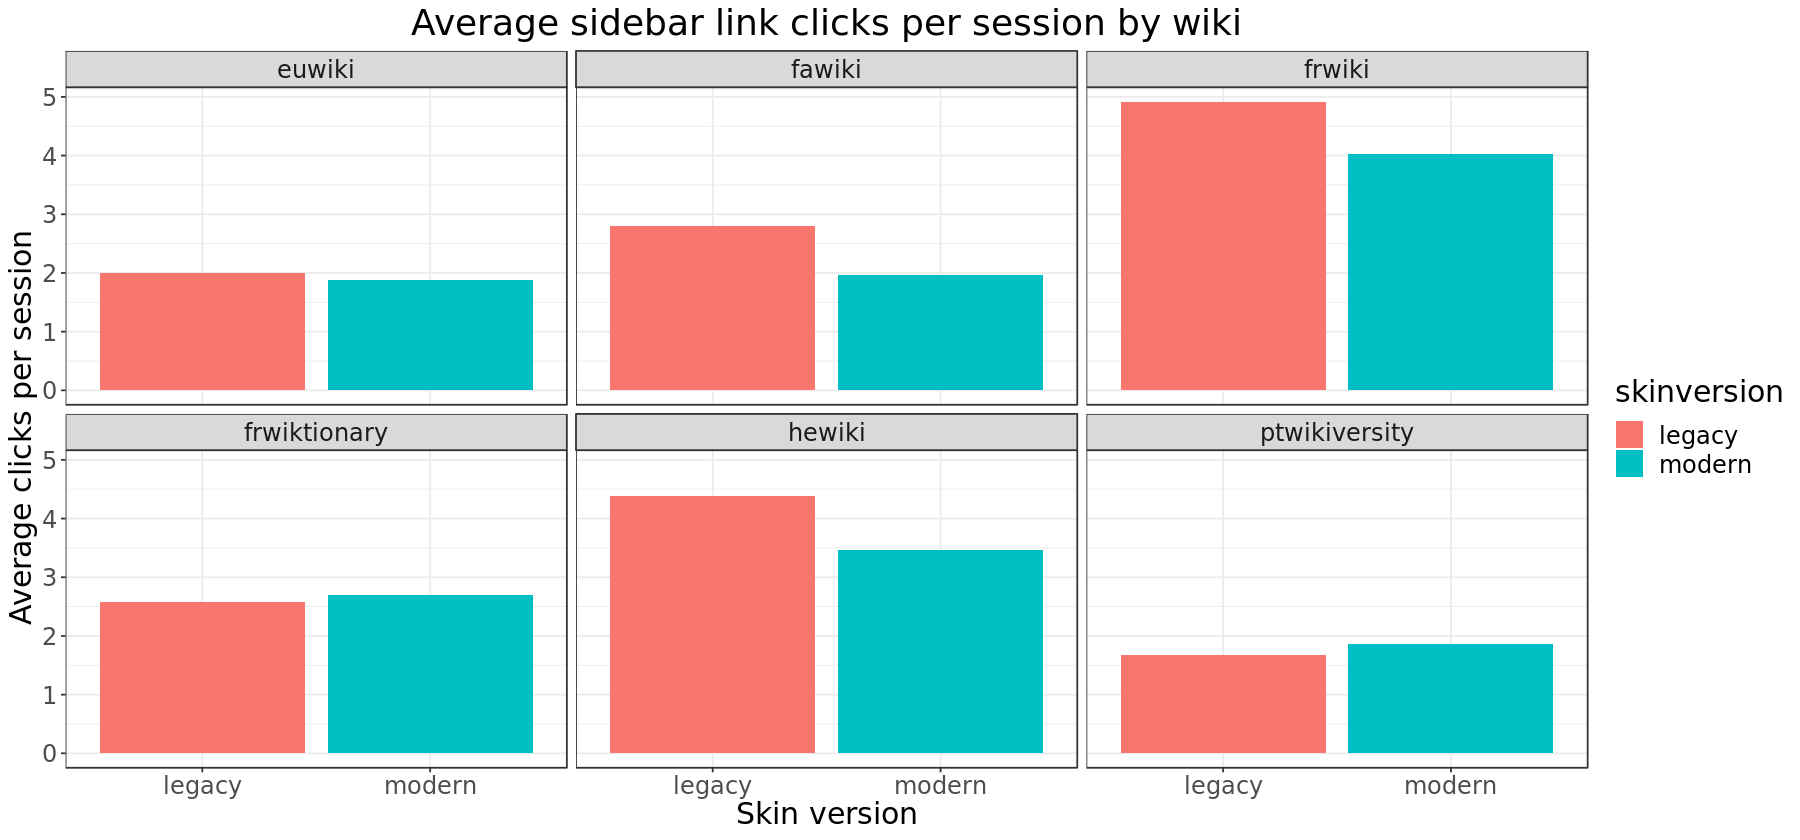

In [985]:
p <- sidebarlink_clicks_persession_bywiki %>%
    ggplot(aes(x= skinversion, y = avg_events_persession, fill = skinversion)) +
    geom_col() +
        facet_wrap(~wiki) +
        scale_y_continuous("Average clicks per session") +
        scale_x_discrete("Skin version") +
        labs(title = "Average sidebar link clicks per session by wiki")  +
        theme_bw() +
        theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=18)) 
p

ggsave("Figures/average_sidebar_link_events_bywiki.png", p, width = 16, height = 8, units = "in", dpi = 300)

French Wiktionary and Portuguese Wikiversity have a slightly higher average number of sidebar link clicks on the modern skin compared to legacy. For the Wikipedia test projects, there is a slightly higher average number of sidebar link clicks on the legacy skin compared to modern.

### What percent of sessions by wiki include a click to the sidebar link?

In [552]:
sidebar_link_click_sessions_wiki <- sidebar_link_clicks %>%
    group_by(skinversion, wiki) %>%
    summarise(num_sessions = n_distinct(session),
             sessions_w_linkclick = sum(sidebar_link_click > 0),
             pct_click_sessions = sessions_w_linkclick/num_sessions *100 ) %>%
    arrange(wiki)

sidebar_link_click_sessions_wiki

`summarise()` regrouping output by 'skinversion' (override with `.groups` argument)



skinversion,wiki,num_sessions,sessions_w_linkclick,pct_click_sessions
<fct>,<chr>,<int>,<int>,<dbl>
legacy,euwiki,325,9,2.7692308
modern,euwiki,33823,490,1.4487183
legacy,fawiki,67570,1142,1.6900992
modern,fawiki,2564847,6626,0.2583390
legacy,frwiki,5937650,13574,0.2286090
modern,frwiki,16351720,35920,0.2196711
legacy,frwiktionary,1566,264,16.8582375
modern,frwiktionary,730118,1522,0.2084595
legacy,hewiki,52779,2586,4.8996760


There are fewer sessions and clicks for the legacy skin version for the test wikis since the modern skin version was provided as default.

For the larger test wikis, the number of sessions with a recorded click to one of the sidebar links is only slightly higher on legacy.

### By User Edit Count

#### Average events per session by user edit count and skin type

In [482]:

sidebarlink_clicks_persession_byeditcount <- sidebar_link_interactions %>%
    group_by(user_edit_count, skinversion) %>%
    summarize(total_events = sum(events),
              unique_sessions = n_distinct(session),
              avg_events = total_events/unique_sessions)  %>%
    arrange(desc(user_edit_count))

sidebarlink_clicks_persession_byeditcount

`summarise()` regrouping output by 'user_edit_count' (override with `.groups` argument)



user_edit_count,skinversion,total_events,unique_sessions,avg_events
<chr>,<fct>,<int>,<int>,<dbl>
5-99 edits,legacy,600,300,2.000000
5-99 edits,modern,1528,528,2.893939
1000+ edits,legacy,13775,3569,3.859625
1000+ edits,modern,6742,2464,2.736201
100-999 edits,legacy,1503,563,2.669627
100-999 edits,modern,2149,694,3.096542
1-4 edits,legacy,216,121,1.785124
1-4 edits,modern,627,376,1.667553
0 edits,legacy,54421,10570,5.148628


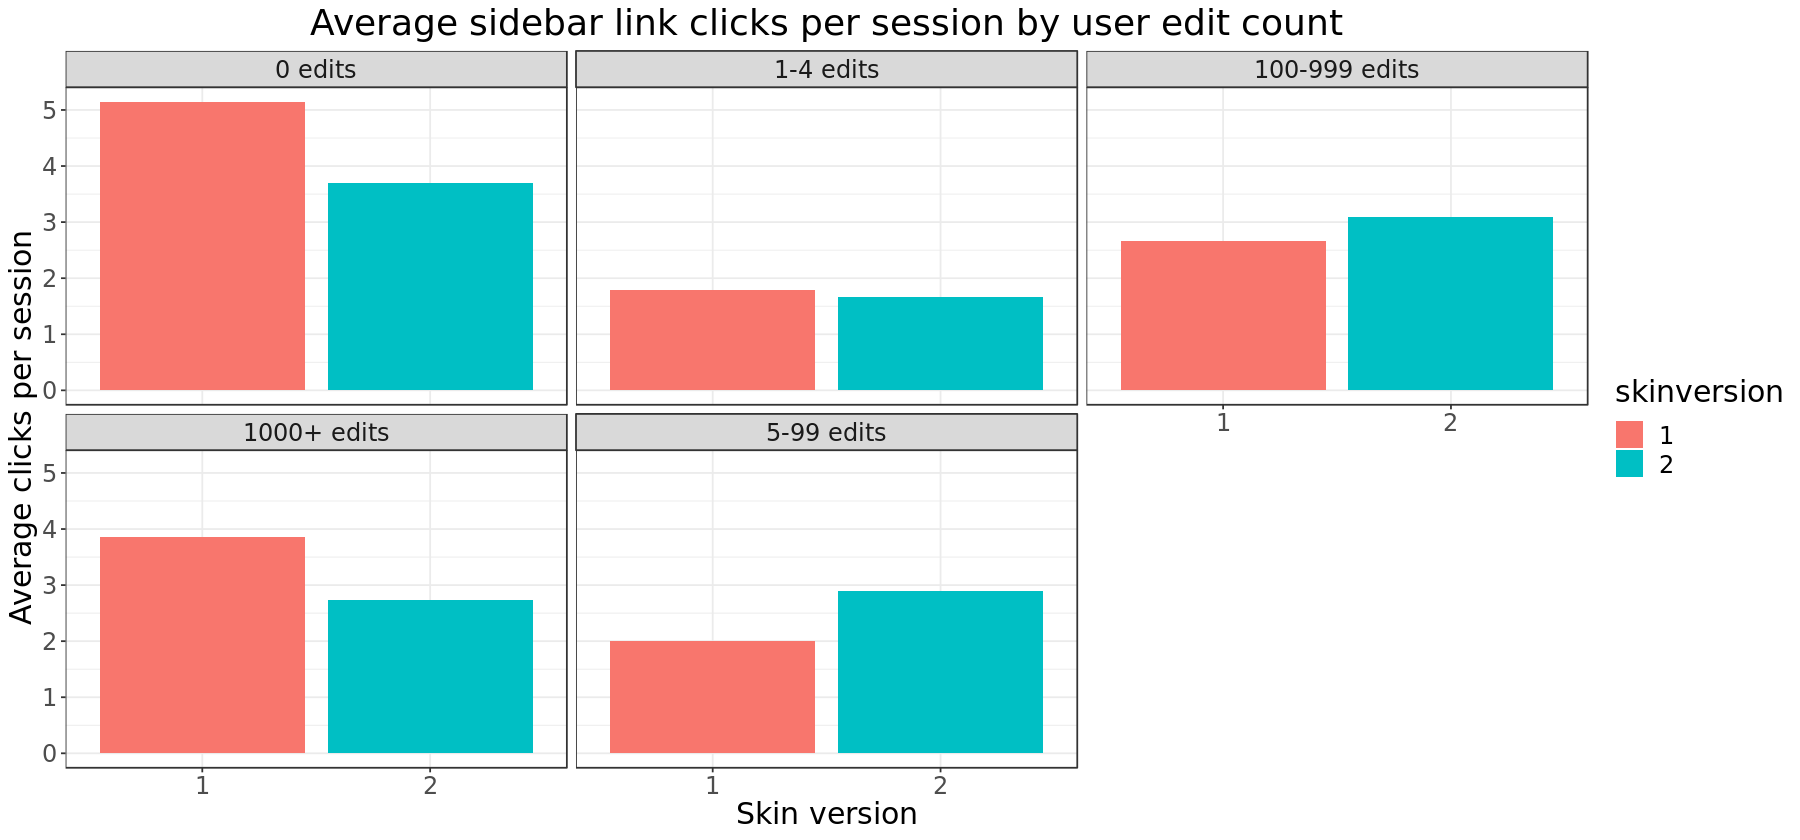

In [986]:
p <- sidebarlink_clicks_persession_byeditcount %>%
    ggplot(aes(x= skinversion, y = avg_events, fill = skinversion)) +
    geom_col() +
        facet_wrap(~user_edit_count) +
        scale_y_continuous("Average clicks per session") +
        scale_x_discrete("Skin version") +
        labs(title = "Average sidebar link clicks per session by user edit count")  +
        theme_bw() +
        theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=18)) 
p


ggsave("Figures/average_sidebar_link_events_byeditcount.png", p, width = 16, height = 8, units = "in", dpi = 300)

Users with between 5 and 999 cumulative edits had a higher number of average sidebar clicks links per session on the modern skin compared to legacy.

### What percent of sessions include a click to the sidebar link by user edit count?

In [554]:
sidebar_link_click_sessions_editcount <- sidebar_link_clicks %>%
    group_by(skinversion, user_edit_count) %>%
    summarise(num_sessions = n_distinct(session),
             sessions_w_linkclick = sum(sidebar_link_click > 0),
             pct_click_sessions = sessions_w_linkclick/num_sessions *100 ) %>%
    arrange(user_edit_count)

sidebar_link_click_sessions_editcount

`summarise()` regrouping output by 'skinversion' (override with `.groups` argument)



skinversion,user_edit_count,num_sessions,sessions_w_linkclick,pct_click_sessions
<fct>,<chr>,<int>,<int>,<dbl>
legacy,0 edits,5997754,11436,0.1906714
modern,0 edits,21226266,46246,0.2178716
legacy,1-4 edits,6175,138,2.2348178
modern,1-4 edits,13886,423,3.0462336
legacy,100-999 edits,11705,759,6.4844084
modern,100-999 edits,23165,895,3.8635873
legacy,1000+ edits,37246,4893,13.1369812
modern,1000+ edits,42904,3352,7.8127913
legacy,5-99 edits,13563,354,2.6100420


### Logged In Status

#### Average events per session by logged in status and skin type

In [987]:

sidebarlink_clicks_persession_byanon <- sidebar_link_interactions %>%
    group_by(logged_in_status, skinversion) %>%
    summarize(total_events = sum(events),
              unique_sessions = n_distinct(session),
              avg_events_persession = total_events/unique_sessions)  %>%
    arrange(desc(logged_in_status))

sidebarlink_clicks_persession_byanon

`summarise()` regrouping output by 'logged_in_status' (override with `.groups` argument)



logged_in_status,skinversion,total_events,unique_sessions,avg_events_persession
<chr>,<chr>,<int>,<int>,<dbl>
logged-out,legacy,54148,10408,5.202537
logged-out,modern,154912,41497,3.733089
logged-in,legacy,16367,4686,3.492744
logged-in,modern,11914,4644,2.565461


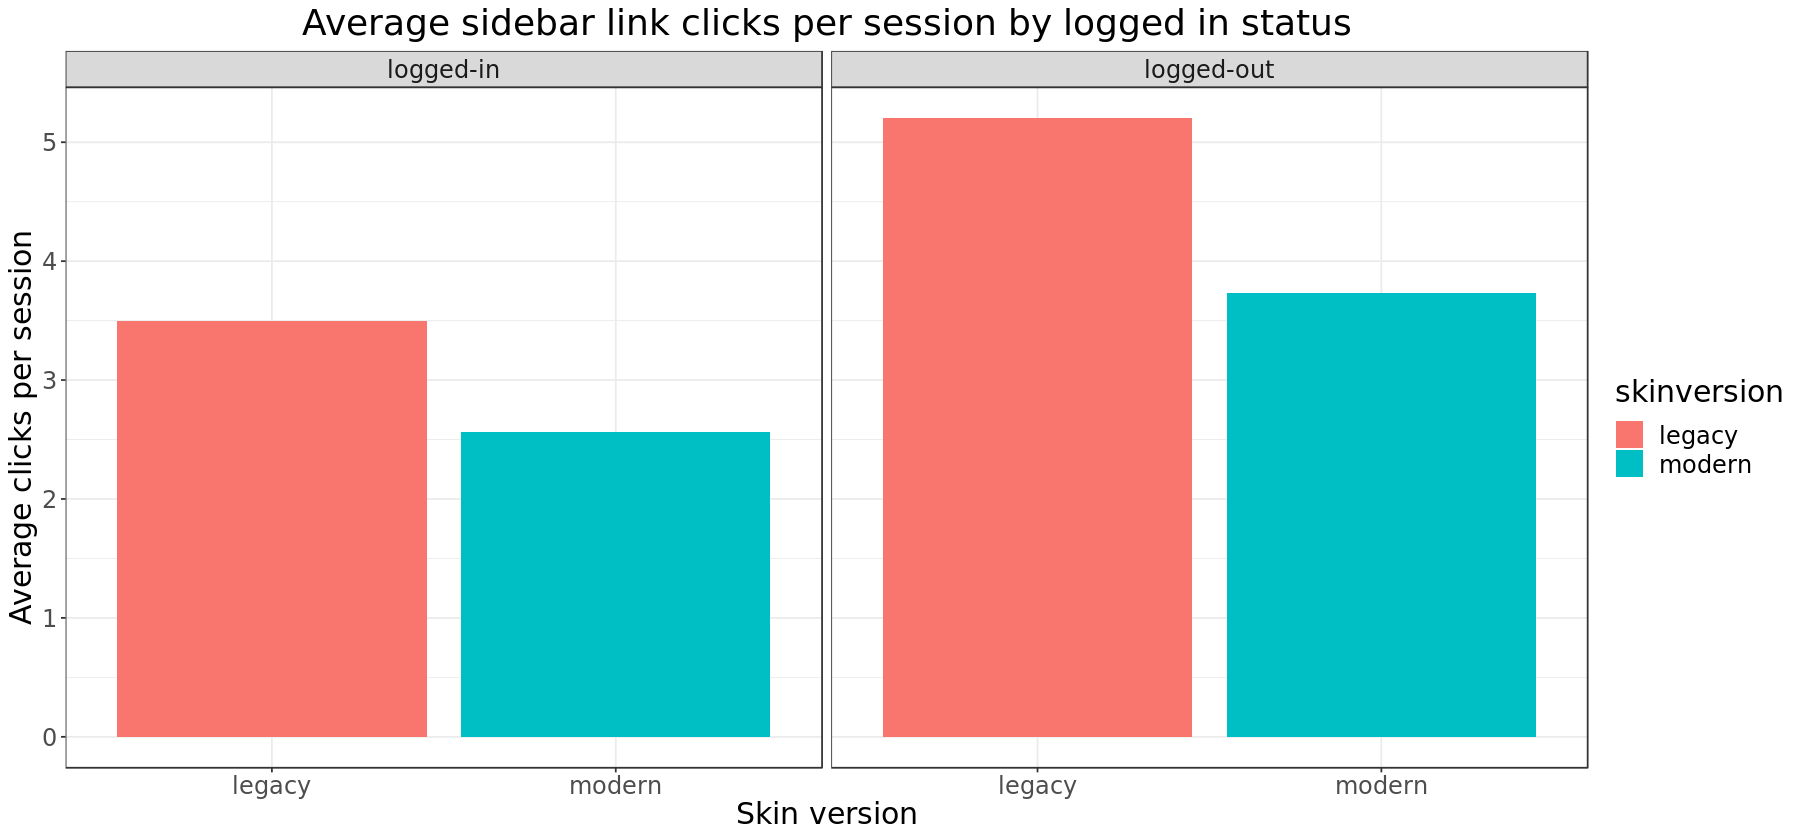

In [988]:
p <- sidebarlink_clicks_persession_byanon %>%
    ggplot(aes(x= skinversion, y = avg_events_persession, fill = skinversion)) +
    geom_col() +
        facet_wrap(~logged_in_status) +
        scale_y_continuous("Average clicks per session") +
        scale_x_discrete("Skin version") +
        labs(title = "Average sidebar link clicks per session by logged in status")  +
        theme_bw() +
        theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=18)) 
p

ggsave("Figures/average_sidebar_link_events_byanon.png", p, width = 16, height = 8, units = "in", dpi = 300)

### What percent of sessions include a click to the sidebar link by logged in status?

In [555]:
sidebar_link_click_sessions_byanon <- sidebar_link_clicks %>%
    group_by(skinversion, logged_in_status) %>%
    summarise(num_sessions = n_distinct(session),
             sessions_w_linkclick = sum(sidebar_link_click > 0),
             pct_click_sessions = sessions_w_linkclick/num_sessions *100 ) %>%
    arrange(logged_in_status)

sidebar_link_click_sessions_byanon

`summarise()` regrouping output by 'skinversion' (override with `.groups` argument)



skinversion,logged_in_status,num_sessions,sessions_w_linkclick,pct_click_sessions
<fct>,<chr>,<int>,<int>,<dbl>
legacy,logged-in,76400,6334,8.2905759
modern,logged-in,129086,6003,4.6503881
legacy,logged-out,5989934,11246,0.1877483
modern,logged-out,21208091,45530,0.2146822


## What is the impact on the donate link?

### Overall - average donate clicks per session

In [1014]:
donate_clicks_persession <- sidebar_link_interactions %>%
    filter(name == 'n-sitesupport') %>%
    group_by(skinversion) %>%
    summarize(total_donate_clicks = sum(events),
              unique_sessions = n_distinct(session),
              avg_dontate_clicks_persession = total_donate_clicks/unique_sessions)  %>%
    arrange(desc(total_donate_clicks))

head(donate_clicks_persession)

`summarise()` ungrouping output (override with `.groups` argument)



skinversion,total_donate_clicks,unique_sessions,avg_dontate_clicks_persession
<chr>,<int>,<int>,<dbl>
modern,1256,1133,1.108561
legacy,172,162,1.061728


### By Wiki

In [1016]:
donate_clicks_persession_wiki <- sidebar_link_interactions %>%
    filter(name == 'n-sitesupport') %>%
    group_by(skinversion, wiki) %>%
    summarize(total_donate_clicks = sum(events),
              unique_sessions = n_distinct(session),
              avg_donate_clicks_persession = total_donate_clicks/unique_sessions)  %>%
    arrange(desc(wiki))

head(donate_clicks_persession_wiki)

`summarise()` regrouping output by 'skinversion' (override with `.groups` argument)



skinversion,wiki,total_donate_clicks,unique_sessions,avg_donate_clicks_persession
<chr>,<chr>,<int>,<int>,<dbl>
modern,ptwikiversity,4,3,1.333333
legacy,hewiki,19,18,1.055556
modern,hewiki,149,118,1.262712
modern,frwiktionary,30,26,1.153846
legacy,frwiki,151,142,1.063380
modern,frwiki,810,758,1.068602


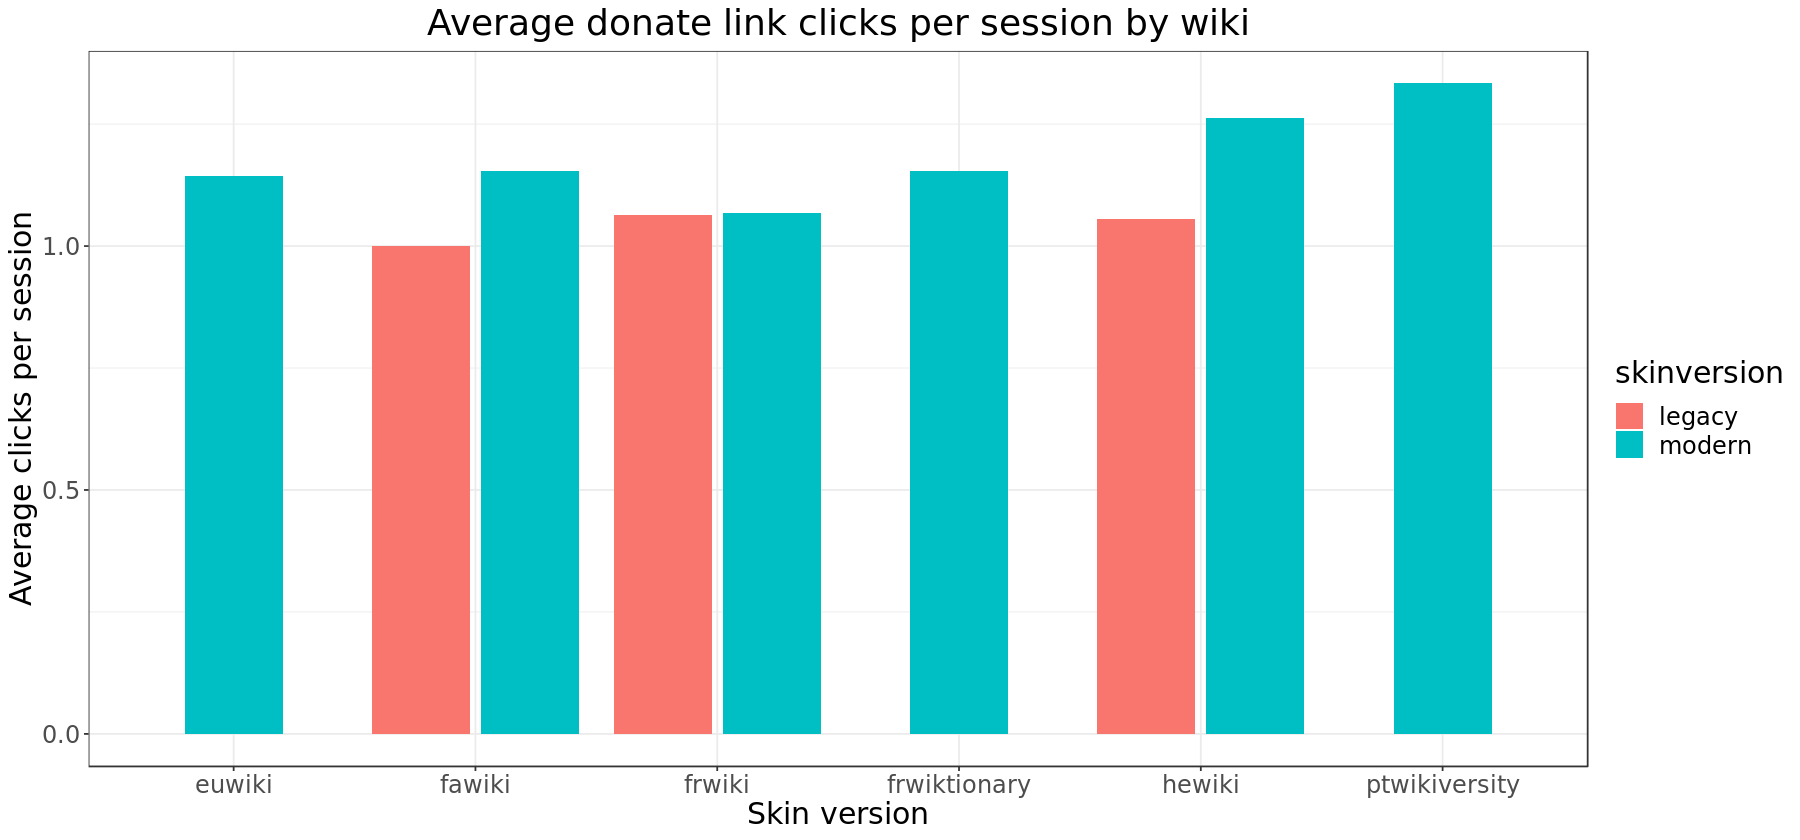

In [995]:
p <- donate_clicks_persession_wiki %>%
    ggplot(aes(x= wiki, y = avg_events_persession, fill = skinversion)) +
    geom_col(position = position_dodge2(width = 0.9, preserve = "single")) +
        scale_y_continuous("Average clicks per session") +
        scale_x_discrete("Skin version") +
        labs(title = "Average donate link clicks per session by wiki")  +
        theme_bw() +
        theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=18)) 
p

ggsave("Figures/average_donate_link_events.png", p, width = 16, height = 8, units = "in", dpi = 300)

On Basque Wikipedia, French Wikitionary, and Portuguese Wikiversity there were no recorded clicks to the donate link in the sidebar on the legacy skin. However, there were few events recorded for these wikis as modern was presented as default to all users. 

For Persian, French, and Hebrew Wikipedia, the modern skin version had a higher average number of donate click links per session.

### By User Edit Count

In [1017]:
donate_clicks_persession_editcount <- sidebar_link_interactions %>%
    filter(name == 'n-sitesupport',
          logged_in_status == 'logged-in') %>%
    group_by(skinversion, user_edit_count) %>%
    summarize(total_donate_clicks = sum(events),
              unique_sessions = n_distinct(session),
              avg_clicks_perssion = total_donate_clicks /unique_sessions)  %>%
    arrange(desc(user_edit_count))

head(donate_clicks_persession_editcount)

`summarise()` regrouping output by 'skinversion' (override with `.groups` argument)



skinversion,user_edit_count,total_donate_clicks,unique_sessions,avg_clicks_perssion
<chr>,<chr>,<int>,<int>,<dbl>
legacy,5-99 edits,3,3,1.000000
modern,5-99 edits,8,8,1.000000
legacy,1000+ edits,15,13,1.153846
modern,1000+ edits,11,11,1.000000
legacy,100-999 edits,4,4,1.000000
modern,100-999 edits,8,7,1.142857


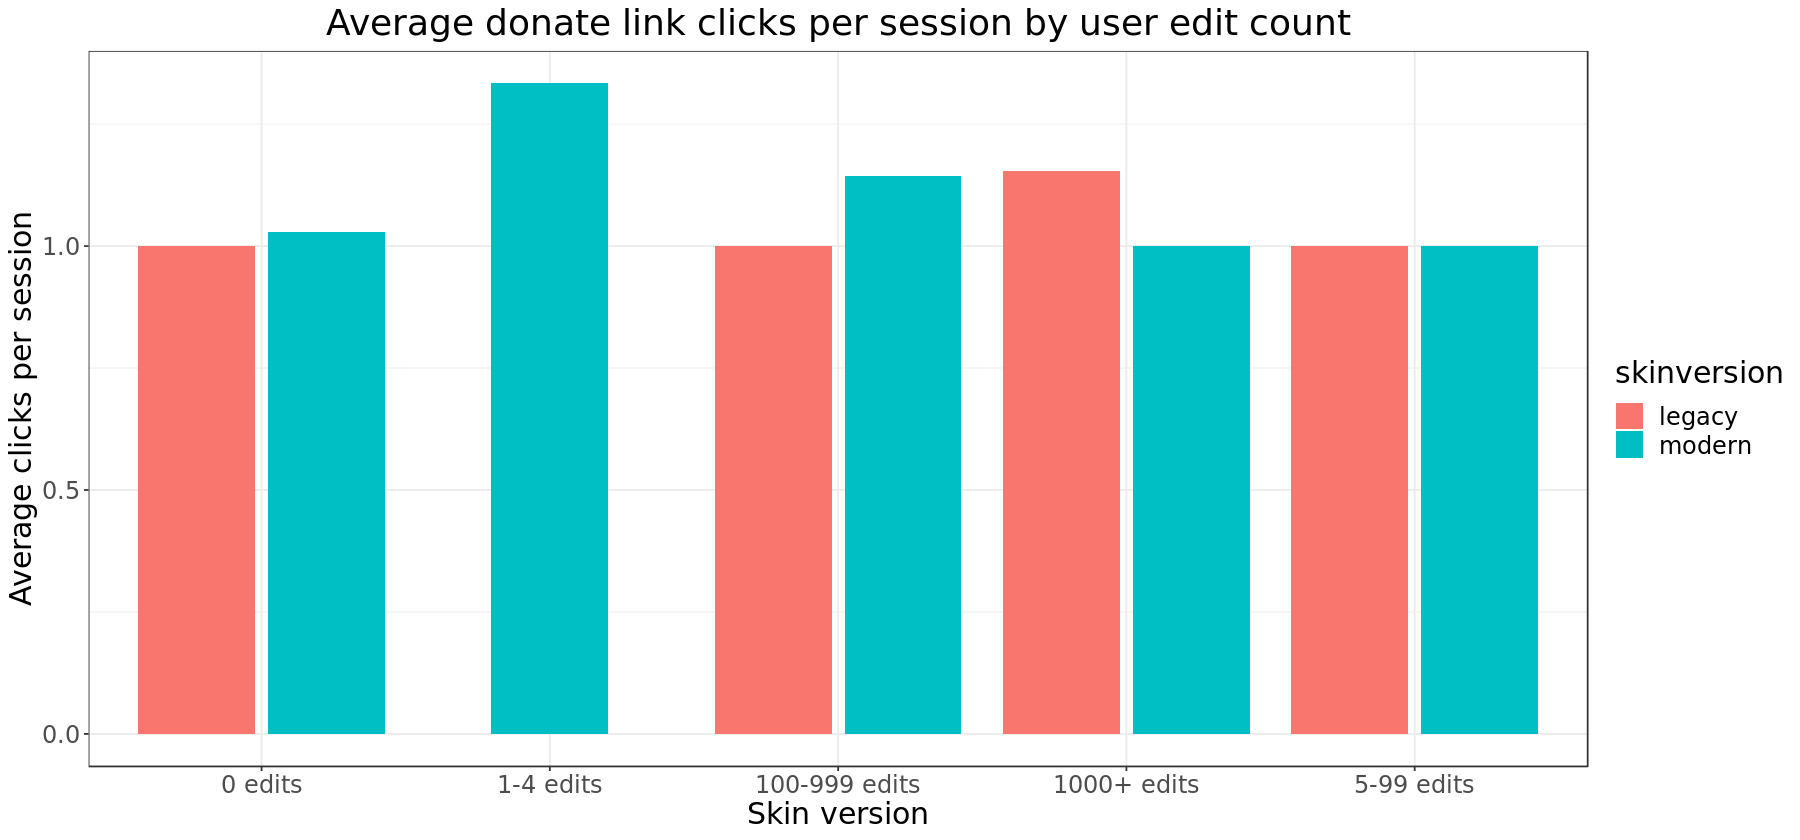

In [999]:
p <- donate_clicks_persession_editcount %>%
    ggplot(aes(x= user_edit_count, y = avg_events_perssion, fill = skinversion)) +
    geom_col(position = position_dodge2(width = 0.9, preserve = "single")) +
        scale_y_continuous("Average clicks per session") +
        scale_x_discrete("Skin version") +
        labs(title = "Average donate link clicks per session by user edit count")  +
        theme_bw() +
        theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=18)) 
p


ggsave("Figures/average_donate_link_events_byeditcount.png", p, width = 16, height = 8, units = "in", dpi = 300)

The average clicks to the donate link per session were higher on the modern desktop skin for users with 0 edits and 100-999 edits.  Users with over 100+0 edits had a higher number of clicks to the donate link on legacy.

No donate link clicks were recorded for users with 1-4 edits on the legacy skin. Note: To view the legacy skin, users would have needed to opt-out, which resulted in a fewer number of events on these wikis.


### By Logged in Status

In [1018]:
donate_clicks_persession_byanon <- sidebar_link_interactions %>%
    filter(name == 'n-sitesupport') %>%
    group_by(skinversion, logged_in_status) %>%
    summarize(total_donate_clicks = sum(events),
              unique_sessions = n_distinct(session),
              avg_clicks_persession = total_donate_clicks/unique_sessions)  %>%
    arrange(desc(logged_in_status))

head(donate_clicks_persession_byanon)

`summarise()` regrouping output by 'skinversion' (override with `.groups` argument)



skinversion,logged_in_status,total_donate_clicks,unique_sessions,avg_clicks_persession
<chr>,<chr>,<int>,<int>,<dbl>
legacy,logged-out,146,138,1.057971
modern,logged-out,1177,1060,1.110377
legacy,logged-in,26,24,1.083333
modern,logged-in,79,73,1.082192


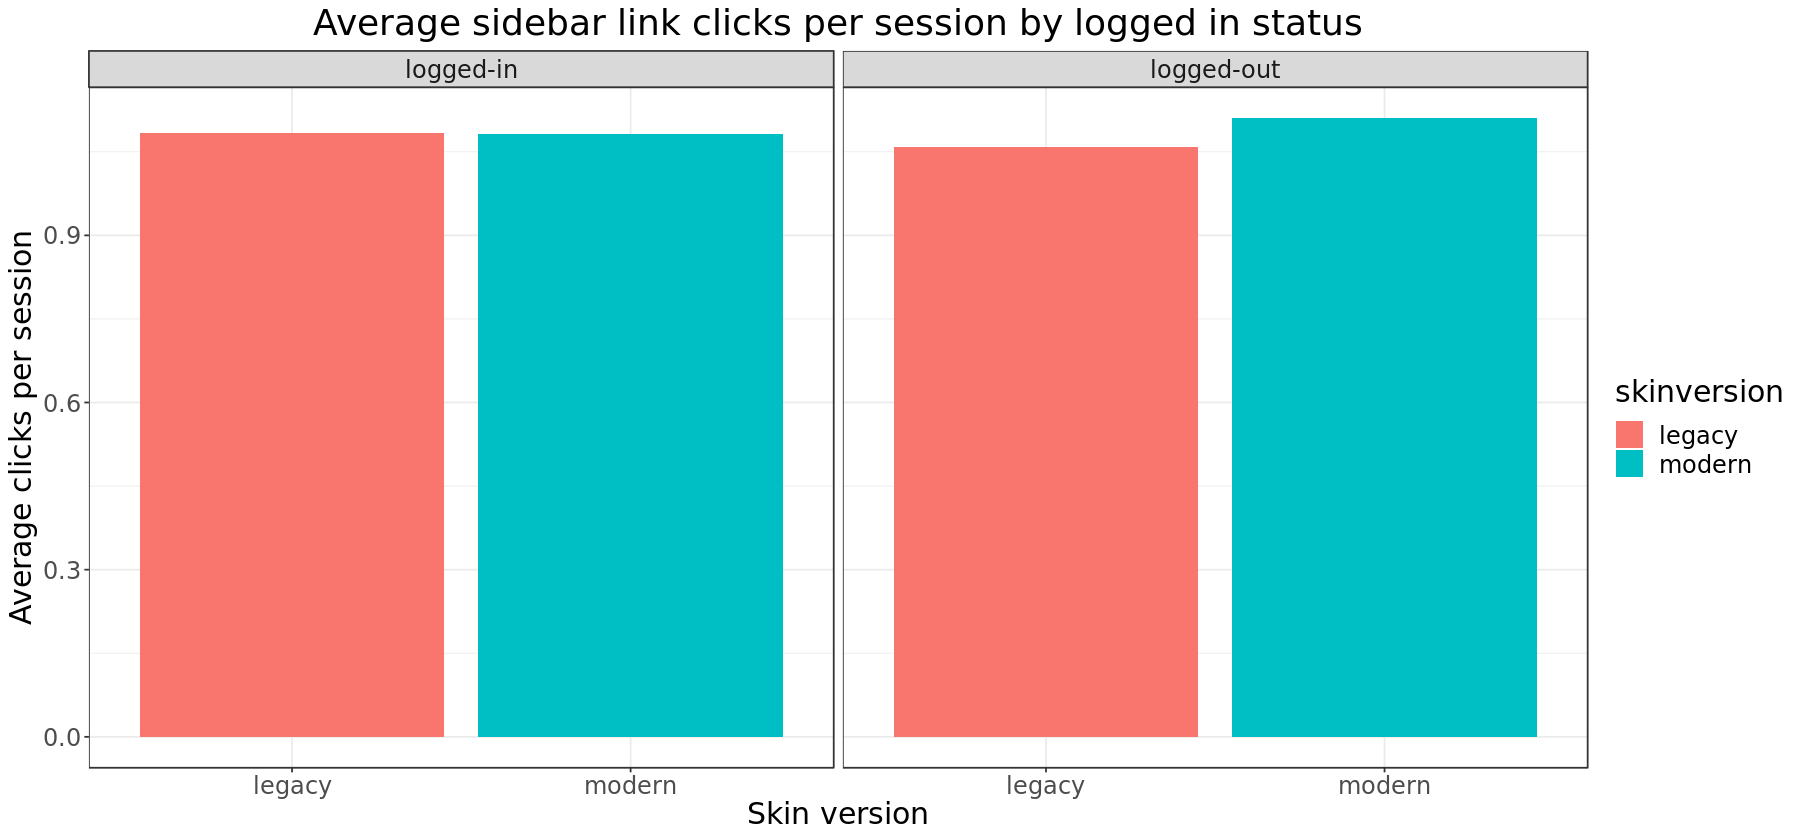

In [1002]:
p <- donate_clicks_persession_byanon%>%
    ggplot(aes(x= skinversion, y = avg_events_persession, fill = skinversion)) +
    geom_col() +
        facet_wrap(~logged_in_status) +
        scale_y_continuous("Average clicks per session") +
        scale_x_discrete("Skin version") +
        labs(title = "Average sidebar link clicks per session by logged in status")  +
        theme_bw() +
        theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=18)) 
p

ggsave("Figures/average_donate_link_events_byanont.png", p, width = 16, height = 8, units = "in", dpi = 300)

There were no signficant difference in the avaerage donate clicks between logged in and logged out users. The modern desktop skin saw a slightly higher average number of dontate link clicks for logged out users. 

## What is the difference in sidebar link interactions pre and post deployment?

Approach/Caveats: 
- Obtained internal requests to the common sidebar links from the test wikis using [webrequest](https://wikitech.wikimedia.org/wiki/Analytics/Data_Lake/Traffic/Webrequest) as current desktop instrumentation was not yet available.
- Special Pages are no longer counted as pageviews per the new pageview definition so I used uri_path requests from webrequests.
- Since the sidebar differs for each wiki, I reviewed wikis separately and reviewed the most frequently viewed links for each wiki.  
- Requests to donate link are unfortunately not available in webrequest.
- Compared pageviews two weeks before and two weeks after the deployment. Since data is only available in webrequest for 90 days, we are unable to do a year over year comparison so any changes reported below may be inflated by seasonalitly effects.



### Post Deployment Change in Sidebar Link Views - Two weeks before and after Deployment
***Based on sample of data from webrequest*** 

| Wiki | Logged In | Logged Out | Overall
|------|-----------|------------|------------|
|  frwiki    |   7.44%        |   -11.14%         | -10.5% |
|  hewiki    |     -4.55%      |   -11.01%         |-10.29%|
|  fawiki    |    22.67%       |   13.17%         | 14.08%|
|  euwiki[1]    |      0.00%     |     -45.63%       |-43.84%|
|  frwiktionary[1]    |      -29.41%     |     -31.42%      |-31.25%|
|  ptwikiversity[1]    |    0.0%       |     29.03%       |25.71%|

[1] Percent change numbers are inflated due to a smaller sample size available for these wikis in webrequest

There was a small decrease (-9.15%) in the overall total number of sidebar link interactions comparing the two weeks prior and two week following deployment of the collapsible sidebar for each wiki; however, this percentage is likely inflated due to seasonalilty effects. 

Data for the previous year was not available so we are not able to complete a year over year analysis to account for any seasonality impacts; however, a review of all internal desktop pageviews over the reviewed timeframe shows a slight decrease on the test wikis during this timframe which may account for some of these pre and post deployment decreases in sidebar views. 

Based on this, it appears that the collapsible sidebar likely only had a small impact on the views to the sidebar links. Notably, logged in users for French Wikipedia and logged in and logged out users on Perian Wikipedia saw increases in the total number of sidebar link interactions following the deployment of the collapsible sidebar. See further details in the analysis provided below:

In [710]:
# FrWiki - Deployment Date August 5th
query <- 
"SELECT 
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')) AS date,
    IF(x_analytics_map['loggedIn'] = '1', 'logged-in', 'logged-out') as logged_in_status,
    SUM(IF((uri_path = '/wiki/Wikip%C3%A9dia:Accueil_principal'), 1, 0)) AS main_page,
    SUM(IF((uri_path = '/wiki/Sp%C3%A9cial:Page_au_hasard'), 1, 0)) AS random_page,
    SUM(IF((uri_path = '/wiki/Portail:Accueil'), 1, 0)) AS contents,
    SUM(IF((uri_path = '/wiki/Wikip%C3%A9dia:Contact'), 1, 0)) AS contact, 
    SUM(IF((uri_path = '/wiki/Aide:Accueil'), 1, 0)) AS help,
    SUM(IF((uri_path  = '/wiki/Wikip%C3%A9dia:Accueil_de_la_communaut%C3%A9'), 1, 0)) AS community_portal,
    SUM(IF((uri_path = '/wiki/Sp%C3%A9cial:Modifications_r%C3%A9centes'), 1, 0)) AS recent_changes
FROM wmf.webrequest TABLESAMPLE(BUCKET 1 OUT OF 128 ON hostname, sequence)
WHERE
    year = 2020
--review two weeks before and after
    AND ((month=07 AND day >= 22) OR (month= 08 and day <= 18)) 
    AND agent_type = 'user'
    AND normalized_host.project_family = 'wikipedia'
    AND normalized_host.project = 'fr'
    AND access_method = 'desktop'
    AND referer_class = 'internal' --isolate to only views to these pages from within wikipedia. 
    AND webrequest_source = 'text'
GROUP BY
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')),
    IF(x_analytics_map['loggedIn'] = '1', 'logged-in', 'logged-out')"

In [711]:
frwiki_sidebar_link_views <- wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



### French Wikipedia

In [732]:
frwiki_pre_post_deploy <- frwiki_sidebar_link_views %>%
    gather(sidebar_link, n_views, 3:9) %>%
    mutate(deploy_status = ifelse(date >= '2020-07-22' & date < '2020-08-05', "pre_deploy", "post_deploy")) %>%
    group_by(logged_in_status, deploy_status) %>%
    summarize(n_views = sum(n_views)) 


frwiki_pre_post_deploy

`summarise()` regrouping output by 'logged_in_status' (override with `.groups` argument)



logged_in_status,deploy_status,n_views
<chr>,<chr>,<int>
logged-in,post_deploy,260
logged-in,pre_deploy,242
logged-out,post_deploy,6048
logged-out,pre_deploy,6806


In [707]:
# HeWiki - Deployment Date on July 28th
query <- 
"SELECT 
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')) AS date,
    IF(x_analytics_map['loggedIn'] = '1', 'logged-in', 'logged-out') as logged_in_status,
    SUM(IF((uri_path = '/wiki/%D7%A2%D7%9E%D7%95%D7%93_%D7%A8%D7%90%D7%A9%D7%99'), 1, 0)) AS main_page,
    SUM(IF((uri_path = '/wiki/%D7%9E%D7%99%D7%95%D7%97%D7%93:%D7%90%D7%A7%D7%A8%D7%90%D7%99'), 1, 0)) AS random_page,
    SUM(IF((uri_path = '/wiki/%D7%A4%D7%95%D7%A8%D7%98%D7%9C:%D7%A4%D7%95%D7%A8%D7%98%D7%9C%D7%99%D7%9D'), 1, 0)) AS contents,
    SUM(IF((uri_path = '/wiki/%D7%95%D7%99%D7%A7%D7%99%D7%A4%D7%93%D7%99%D7%94:%D7%99%D7%A6%D7%99%D7%A8%D7%AA_%D7%A7%D7%A9%D7%A8'), 1, 0)) AS contact, 
    SUM(IF((uri_path = '/wiki/%D7%A2%D7%96%D7%A8%D7%94:%D7%AA%D7%A4%D7%A8%D7%99%D7%98_%D7%A8%D7%90%D7%A9%D7%99'), 1, 0)) AS help,
    SUM(IF((uri_path = '/wiki/%D7%95%D7%99%D7%A7%D7%99%D7%A4%D7%93%D7%99%D7%94:%D7%A9%D7%A2%D7%A8_%D7%94%D7%A7%D7%94%D7%99%D7%9C%D7%94'), 1, 0)) AS community_portal,
    SUM(IF((uri_path = '/wiki/%D7%9E%D7%99%D7%95%D7%97%D7%93:%D7%A9%D7%99%D7%A0%D7%95%D7%99%D7%99%D7%9D_%D7%90%D7%97%D7%A8%D7%95%D7%A0%D7%99%D7%9D'), 1, 0)) AS recent_changes
FROM wmf.webrequest TABLESAMPLE(BUCKET 1 OUT OF 64 ON hostname, sequence)
WHERE 
    year = 2020
    AND ((month=07 AND day >= 14) OR (month= 08 and day <= 10)) 
    AND agent_type = 'user'
    AND normalized_host.project_family = 'wikipedia'
    AND normalized_host.project = 'he'
    AND access_method = 'desktop'
    AND referer_class = 'internal' --isolate to only views to these pages from within wikipedia. 
    AND webrequest_source = 'text'
GROUP BY
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')),
    IF(x_analytics_map['loggedIn'] = '1', 'logged-in', 'logged-out')"

In [708]:
hewiki_sidebar_link_views <- wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



### Hebrew Wikipedia

In [734]:
hewiki_pre_post_deploy <- hewiki_sidebar_link_views %>%
    gather(sidebar_link, n_views, 3:9) %>%
    mutate(deploy_status = ifelse(date >= '2020-07-14' & date < '2020-07-28', "pre_deploy", "post_deploy")) %>%
    group_by(logged_in_status, deploy_status) %>%
    summarize(n_views = sum(n_views))


hewiki_pre_post_deploy

`summarise()` regrouping output by 'logged_in_status' (override with `.groups` argument)



logged_in_status,deploy_status,n_views
<chr>,<chr>,<int>
logged-in,post_deploy,420
logged-in,pre_deploy,440
logged-out,post_deploy,3112
logged-out,pre_deploy,3497


In [704]:
# FaWiki - deployment date July 28th
query <- 
"SELECT 
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')) AS date,
    IF(x_analytics_map['loggedIn'] = '1', 'logged-in', 'logged-out') as logged_in_status,
    SUM(IF((uri_path ='/wiki/%D8%B5%D9%81%D8%AD%D9%87%D9%94_%D8%A7%D8%B5%D9%84%DB%8C'), 1, 0)) AS main_page,
    SUM(IF((uri_path = '/wiki/%D9%88%DB%8C%DA%98%D9%87:%D8%B5%D9%81%D8%AD%D9%87%D9%94_%D8%AA%D8%B5%D8%A7%D8%AF%D9%81%DB%8C'), 1, 0)) AS random_page,
    SUM(IF((uri_path = '/wiki/%D9%88%DB%8C%DA%A9%DB%8C%E2%80%8C%D9%BE%D8%AF%DB%8C%D8%A7:%D8%AA%D9%85%D8%A7%D8%B3_%D8%A8%D8%A7_%D9%85%D8%A7'), 1, 0)) AS contact, 
    SUM(IF((uri_path = '/wiki/%D8%B1%D8%A7%D9%87%D9%86%D9%85%D8%A7:%D9%81%D9%87%D8%B1%D8%B3%D8%AA'), 1, 0)) AS help,
    SUM(IF((uri_path = '/wiki/%D9%88%DB%8C%DA%98%D9%87:%D8%AA%D8%BA%DB%8C%DB%8C%D8%B1%D8%A7%D8%AA_%D8%A7%D8%AE%DB%8C%D8%B1'), 1, 0)) AS recent_changes
FROM wmf.webrequest TABLESAMPLE(BUCKET 1 OUT OF 64 ON hostname, sequence)
WHERE
    year = 2020
    AND ((month=07 AND day >= 14) OR (month= 08 and day <= 10)) 
    AND agent_type = 'user'
    AND normalized_host.project_family = 'wikipedia'
    AND normalized_host.project = 'fa'
    AND access_method = 'desktop'
    AND referer_class = 'internal' --isolate to only views to these pages from within wikipedia. 
    AND webrequest_source = 'text'
GROUP BY
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')),
    IF(x_analytics_map['loggedIn'] = '1', 'logged-in', 'logged-out')"

In [705]:
fawiki_sidebar_link_views <- wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



### Persian Wikipedia

In [736]:
fawiki_pre_post_deploy <- fawiki_sidebar_link_views %>%
    gather(sidebar_link, n_views, 3:7) %>%
    mutate(deploy_status = ifelse(date >= '2020-07-14' & date < '2020-07-28', "pre_deploy", "post_deploy")) %>%
    group_by(logged_in_status, deploy_status) %>%
    summarize(n_views = sum(n_views)) 


fawiki_pre_post_deploy

`summarise()` regrouping output by 'logged_in_status' (override with `.groups` argument)



logged_in_status,deploy_status,n_views
<chr>,<chr>,<int>
logged-in,post_deploy,211
logged-in,pre_deploy,172
logged-out,post_deploy,1847
logged-out,pre_deploy,1632


In [701]:
# EuWiki - deployment date July 22nd
query <- 
"SELECT 
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')) AS date,
    IF(x_analytics_map['loggedIn'] = '1', 'logged-in', 'logged-out') as logged_in_status,
    SUM(IF((uri_path = '/wiki/Azala'), 1, 0)) AS main_page,
    SUM(IF((uri_path = '/wiki/Berezi:Ausazkoa'), 1, 0)) AS random_page,
    SUM(IF((uri_path = '/wiki/Laguntza:Sarrera'), 1, 0)) AS help,
    SUM(IF((uri_path = '/wiki/Berezi:AzkenAldaketak'), 1, 0)) AS recent_changes
FROM wmf.webrequest TABLESAMPLE(BUCKET 1 OUT OF 64 ON hostname, sequence)
WHERE 
    year = 2020
    AND ((month=07 AND day >= 08) OR (month= 08 and day <= 04)) 
    AND agent_type = 'user'
    AND normalized_host.project_family = 'wikipedia'
    AND normalized_host.project = 'eu'
    AND access_method = 'desktop'
    AND referer_class = 'internal' --isolate to only views to these pages from within wikipedia. 
    AND webrequest_source = 'text'
GROUP BY
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')),
    IF(x_analytics_map['loggedIn'] = '1', 'logged-in', 'logged-out')"

In [702]:
euwiki_sidebar_link_views <- wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



### Basque Wikipedia

In [738]:
euwiki_pre_post_deploy <- euwiki_sidebar_link_views %>%
    gather(sidebar_link, n_views, 3:6) %>%
    mutate(deploy_status = ifelse(date >= '2020-07-08' & date < '2020-07-22', "pre_deploy", "post_deploy")) %>%
    group_by(logged_in_status, deploy_status) %>%
    summarize(n_views = sum(n_views))

euwiki_pre_post_deploy

`summarise()` regrouping output by 'logged_in_status' (override with `.groups` argument)



logged_in_status,deploy_status,n_views
<chr>,<chr>,<int>
logged-in,post_deploy,23
logged-in,pre_deploy,23
logged-out,post_deploy,305
logged-out,pre_deploy,561


In [728]:
# FrWiktionary - deployment date July 22nd
query <- 
"SELECT 
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')) AS date,
    IF(x_analytics_map['loggedIn'] = '1', 'logged-in', 'logged-out') as logged_in_status,
    SUM(IF((uri_path = '/wiki/Wiktionnaire:Page_d%E2%80%99accueil'), 1, 0)) AS main_page,
    SUM(IF((uri_path = '/wiki/Sp%C3%A9cial:Page_au_hasard'), 1, 0)) AS random_page,
    SUM(IF((uri_path = '/wiki/Wiktionnaire:Portails'), 1, 0)) AS contents,
    SUM(IF((uri_path = '/wiki/Wiktionnaire:Accueil_communautaire'), 1, 0)) AS community_portal,
    SUM(IF((uri_path = '/wiki/Aide:Sommaire'), 1, 0)) AS help,
    SUM(IF((uri_path = '/wiki/Sp%C3%A9cial:Modifications_r%C3%A9centes'), 1, 0)) AS recent_changes
FROM wmf.webrequest TABLESAMPLE(BUCKET 1 OUT OF 64 ON hostname, sequence)
WHERE
    year = 2020
--review two weeks before and after deployment date
    AND ((month=07 AND day >= 08) OR (month= 08 and day <= 04)) 
    AND agent_type = 'user'
    AND normalized_host.project_family = 'wiktionary'
    AND normalized_host.project = 'fr'
    AND access_method = 'desktop'
    AND referer_class = 'internal' --isolate to only views to these pages from within wikipedia. 
    AND webrequest_source = 'text'
GROUP BY
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')),
    IF(x_analytics_map['loggedIn'] = '1', 'logged-in', 'logged-out')"

In [729]:
frwiktionary_sidebar_link_views <- wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



### French Wiktionary

In [740]:
frwiktionary_pre_post_deploy <- frwiktionary_sidebar_link_views %>%
    gather(sidebar_link, n_views, 3:7) %>%
    mutate(deploy_status = ifelse(date >= '2020-07-08' & date < '2020-07-22', "pre_deploy", "post_deploy")) %>%
    group_by(logged_in_status, deploy_status) %>%
    summarize(n_views = sum(n_views)) 

frwiktionary_pre_post_deploy

`summarise()` regrouping output by 'logged_in_status' (override with `.groups` argument)



logged_in_status,deploy_status,n_views
<chr>,<chr>,<int>
logged-in,post_deploy,24
logged-in,pre_deploy,34
logged-out,post_deploy,251
logged-out,pre_deploy,366


In [741]:
# ptwikiversity - deployment date July 22nd

query <- 
"SELECT 
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')) AS date,
    IF(x_analytics_map['loggedIn'] = '1', 'logged-in', 'logged-out') as logged_in_status,
    SUM(IF((uri_path =  '/wiki/P%C3%A1gina_principal'), 1, 0)) AS main_page,
    SUM(IF((uri_path =  '/wiki/Wikiversidade:Portal_comunit%C3%A1rio'), 1, 0)) AS community_portal,
    SUM(IF((uri_path =  '/wiki/Especial:Mudan%C3%A7as_recentes'), 1, 0)) AS recent_changes
-- increase sampling size due to low number of events
FROM wmf.webrequest 
WHERE 
    year = 2020
-- review two weeks before and after deployment date
    AND ((month=07 AND day >= 08) OR (month= 08 and day <= 04)) 
    AND agent_type = 'user'
     AND normalized_host.project_family = 'wikiversity'
    AND normalized_host.project = 'pt'
    AND access_method = 'desktop'
    AND referer_class = 'internal' --isolate to only views to these pages from within wikipedia. 
    AND webrequest_source = 'text'
GROUP BY
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')),
    IF(x_analytics_map['loggedIn'] = '1', 'logged-in', 'logged-out')"

In [742]:
ptwikiversity_sidebar_link_views <- wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



### Portuguese Wikiversity

In [1003]:
ptwikiversity_pre_post_deploy <- ptwikiversity_sidebar_link_views %>%
    gather(sidebar_link, n_views, 3:5) %>%
    mutate(deploy_status = ifelse(date >= '2020-07-08' & date < '2020-07-22', "pre_deploy", "post_deploy")) %>%
    group_by(logged_in_status, deploy_status) %>%
    summarize(n_views = sum(n_views))

ptwikiversity_pre_post_deploy

`summarise()` regrouping output by 'logged_in_status' (override with `.groups` argument)



logged_in_status,deploy_status,n_views
<chr>,<chr>,<int>
logged-in,post_deploy,4
logged-in,pre_deploy,4
logged-out,post_deploy,40
logged-out,pre_deploy,31


### Desktop Pageview Check

I completed a quick review of desktop pageviews on the test wiki to confirm there were no signficant changes around deployment dates and also confirm any overall trends in traffic that might have also impacted the pre and post deployment analysis in sidebar links above. 

In [757]:
query <- " 
SELECT 
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')) AS date,
    project AS wiki,
    SUM(view_count) as pageviews
FROM wmf.projectview_hourly
WHERE 
    agent_type = 'user'
    AND access_method = 'desktop'
    AND year >= 2019
-- only review interactions from within the site
    AND referer_class = 'internal'
    AND project IN ('fr.wikipedia', 'he.wikipedia', 'fa.wikipedia', 'eu.wikipedia', 'fr.wiktionary', 'pt.wikiversity')
GROUP BY
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')),
    project
"

In [758]:
desktop_pageviews <- wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [760]:
desktop_pageviews$date <- as.Date(desktop_pageviews$date, format = "%Y-%m-%d")

In [791]:
# Review year over year changes in search-related traffic
pageviews_yoy <- desktop_pageviews %>%
    filter(date <= '2020-08-26') %>%
  mutate(
    year = factor(year(date))
  ) 
year(pageviews_yoy$date) <- 2020

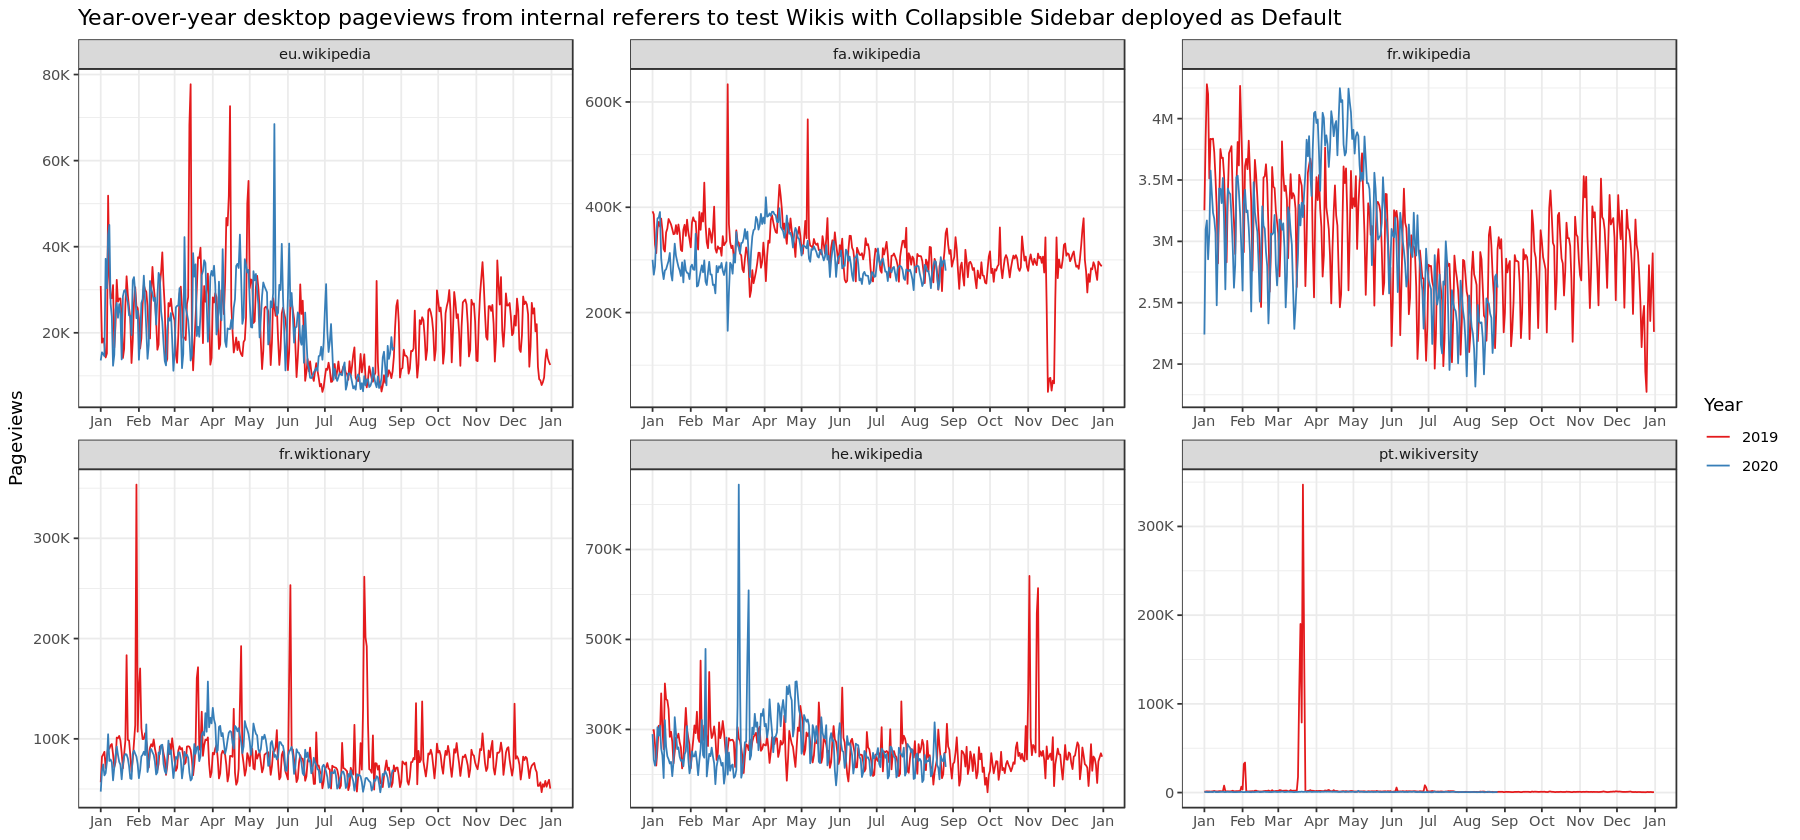

In [1004]:
p <- ggplot(pageviews_yoy, aes(x = date, y = pageviews)) +
  geom_line(aes(color = year)) +
  facet_wrap(~wiki, scales = 'free') +
  scale_x_date(date_labels = "%b", date_breaks = "1 month", minor_breaks = NULL) +
  scale_y_continuous(labels = polloi::compress) +
  scale_color_brewer(palette = "Set1") +
  labs(
    x = NULL, y = "Pageviews", color = "Year",
    title = "Year-over-year desktop pageviews from internal referers to test Wikis with Collapsible Sidebar deployed as Default") +
  theme(legend.position = "bottom") + 
  theme_bw()

p